Combine all the scripts into one so we can feed it all the diffrent city datasets

All the weighted stops stuff is not done here, we only focus on the population and their distance from a stop

1. Get all cities

In [1]:
import glob
import requests as r
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import math as m
import matplotlib.pyplot as plt
import math as m
import haversine as hs
from utils import load_stops_as_dict
from scipy.signal import fftconvolve
import numpy as np 

In [2]:
# visualize and save the populationmap
def visualize(df, city_name):
    BINS = 100
    BLUR = 0.01

    x = df["x"].tolist()
    y = df["y"].tolist()
    weight = df["weight"].tolist()


    fig, ax = plt.subplots()
    data = np.histogram2d(x, y, weights = weight, bins=BINS)[0]
    data = gaussian_filter(data, sigma=BLUR)
    plt.pcolormesh(data.T, cmap='inferno', shading='gouraud')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title(city_name)
    plt.savefig("plots/population_" + city_name + ".png")
    fig.canvas.draw()
    plt.close()

In [3]:
def getindices(lat, lon, LATMIN, LONMIN, LATMAX, LONMAX, GRIDSIZE):

    xind = m.floor(((abs(lat)-abs(LATMIN)) / (abs(LATMAX) - abs(LATMIN))) * GRIDSIZE) # data normalisation to be in the range of 0 - 99
    yind = m.floor(((abs(lon)-abs(LONMIN)) / (abs(LONMAX) - abs(LONMIN))) * GRIDSIZE)

    return [xind,yind]

In [4]:
def convolve_stopgrid(r_orig = 0.15, onepxlength = 1, STOPSGRID = []):

    #assert r_orig <= 1

    # TODO this has to be adapted to the actual selection size. Otherwise the stop radius is too wide
    cx = 30.
    cy = 30.
    r = r_orig/onepxlength

    fx = np.arange(0, 4.5 * r) 
    fy = np.arange(0, 4.5 * r)
    farr = np.zeros((fy.size, fx.size))

    mask = (fx[np.newaxis,:]-cx)**2 + (fy[:,np.newaxis]-cy)**2 < r**2
    farr[mask] = 1.

    kernel = farr
    # CONVOLVEDSTOPSGRID = convolve2d(STOPSGRID, kernel)
    CONVOLVEDSTOPSGRID = fftconvolve(STOPSGRID, kernel) # faster

    return CONVOLVEDSTOPSGRID

In [5]:
def analyze_grids(CONVOLVEDSTOPSGRID, POPULATIONGRID, TOTALPOP):
    populationsum = 0
    for x, poprow in enumerate(POPULATIONGRID):
        for y, poppixle in enumerate(poprow):
            if CONVOLVEDSTOPSGRID[x][y] >= 1:
                populationsum += poppixle

    num = m.floor(populationsum)
    
    return num
    # return num/TOTALPOP

In [6]:
# read dataframe

df = pd.DataFrame()
for i in tqdm(range(1,7)):
    read_df = pd.read_csv("population_data/" + str(i) + ".csv", sep = ",", names = ["y","x","weight"], dtype = np.float64, skiprows = 1)
    df = pd.concat([df, read_df])

100%|██████████| 6/6 [01:50<00:00, 18.35s/it]


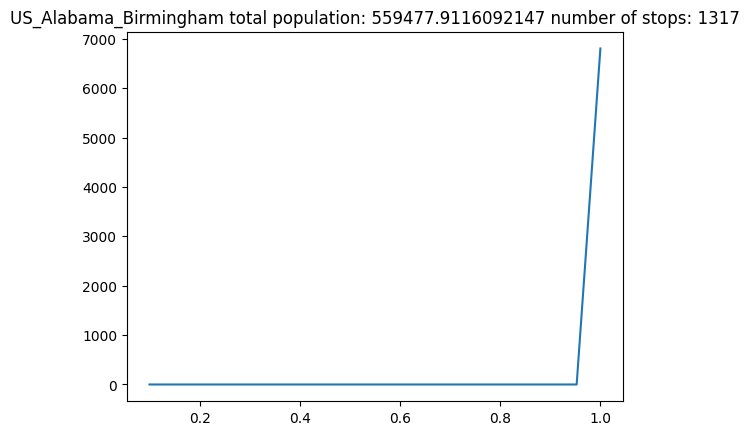

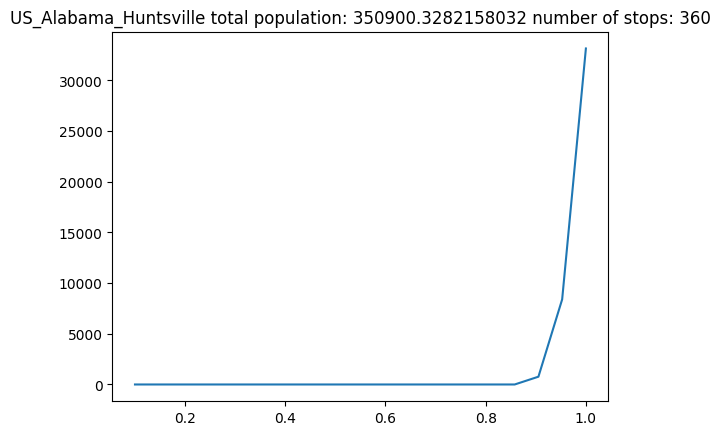

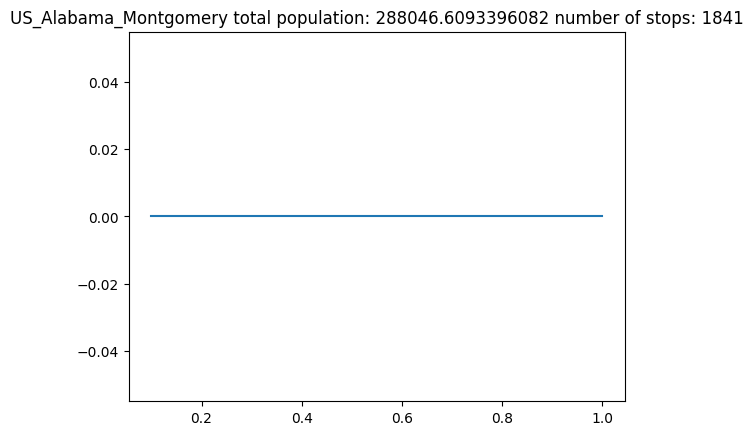

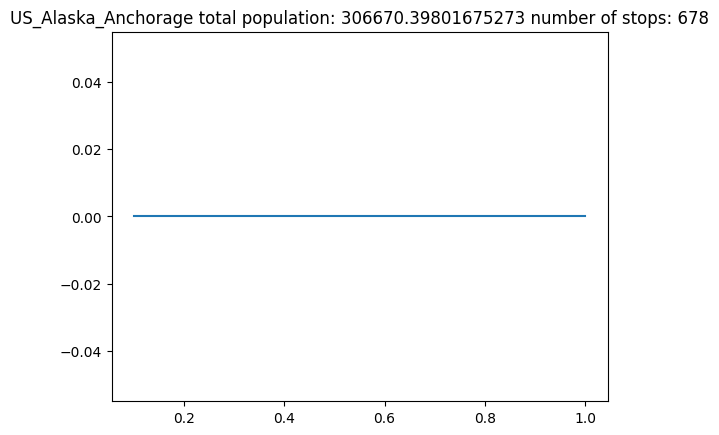

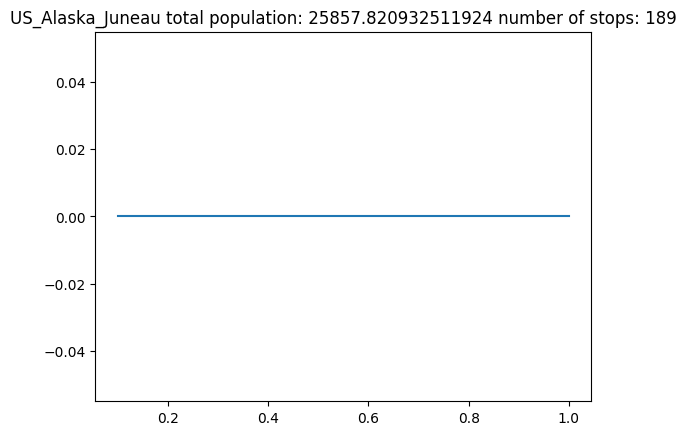

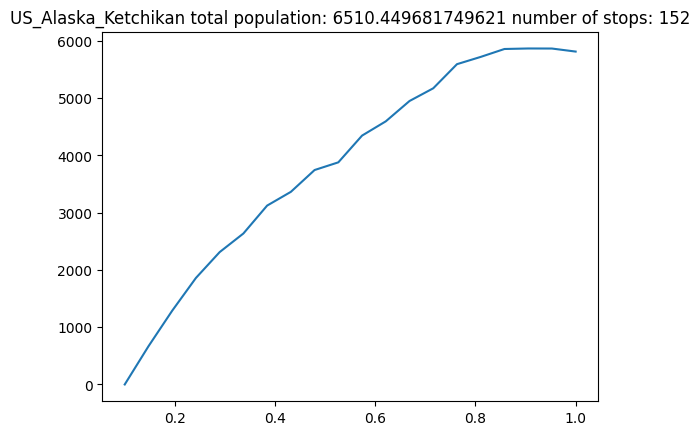

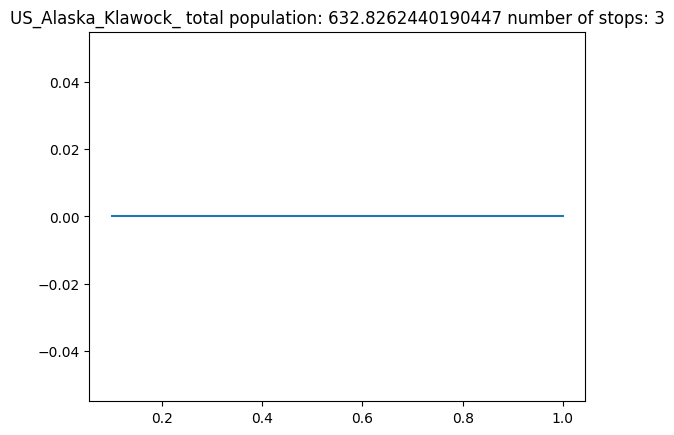

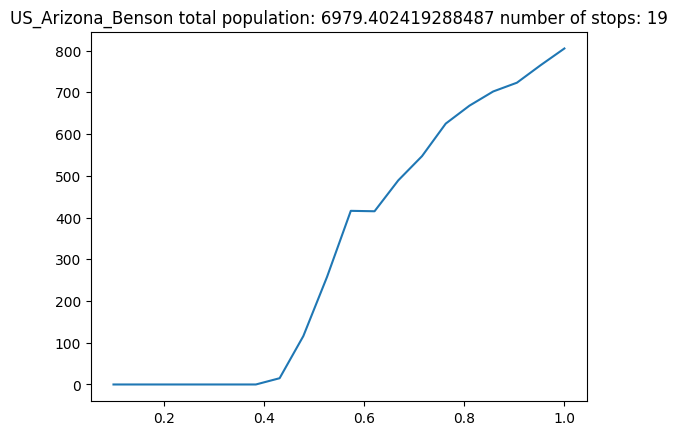

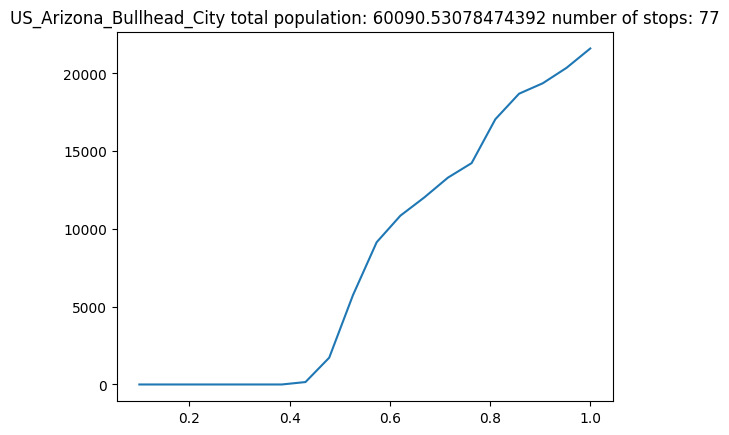

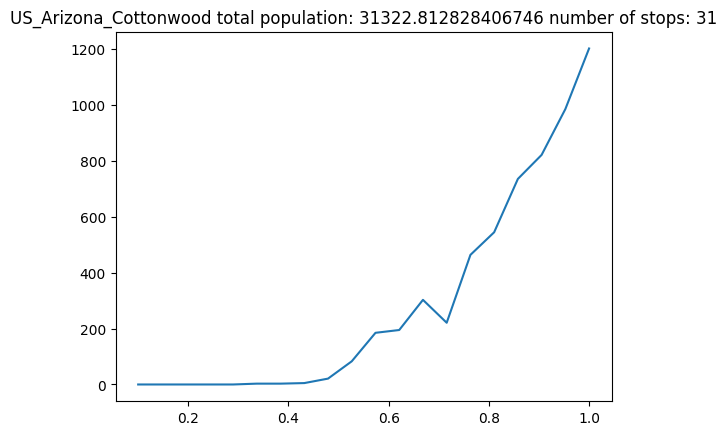

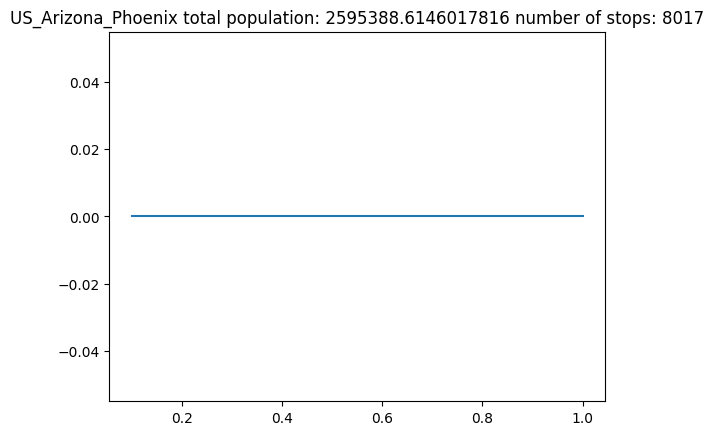

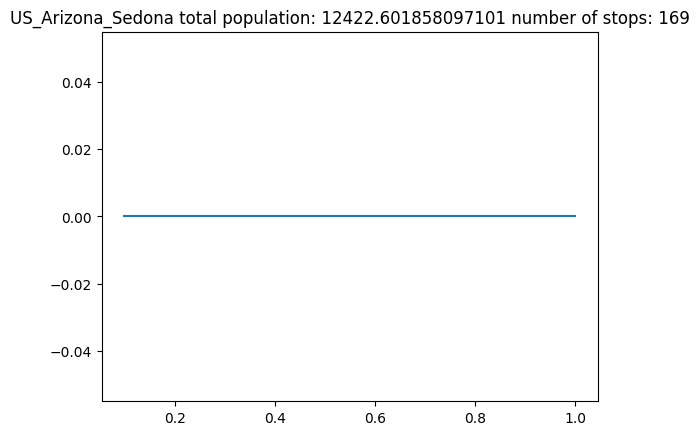

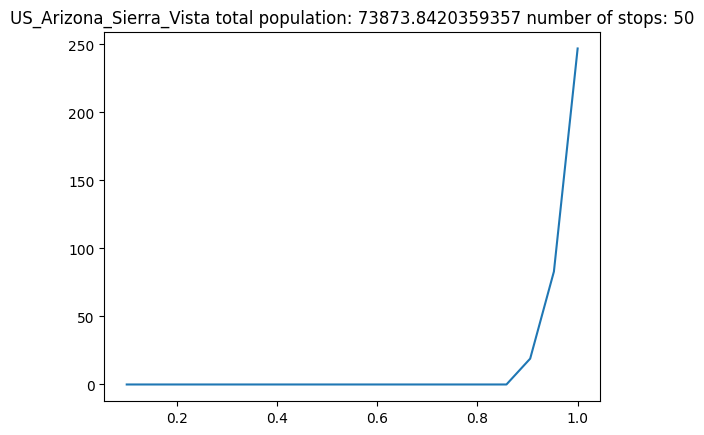

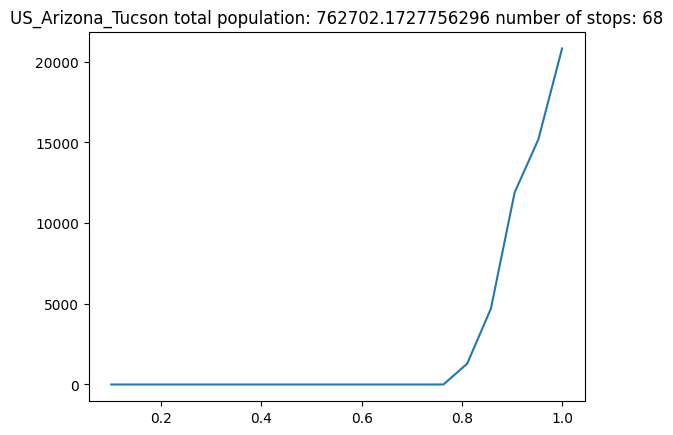

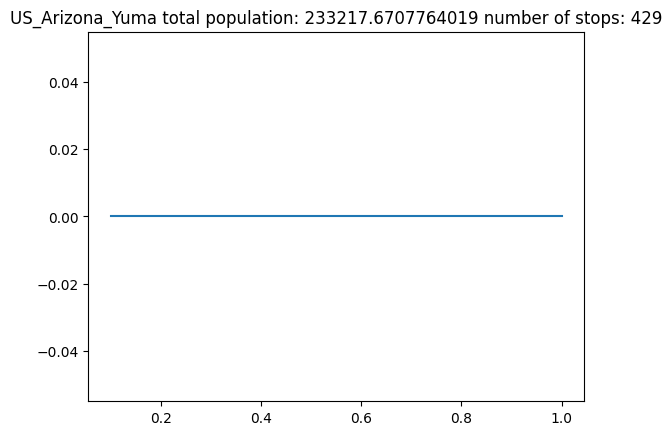

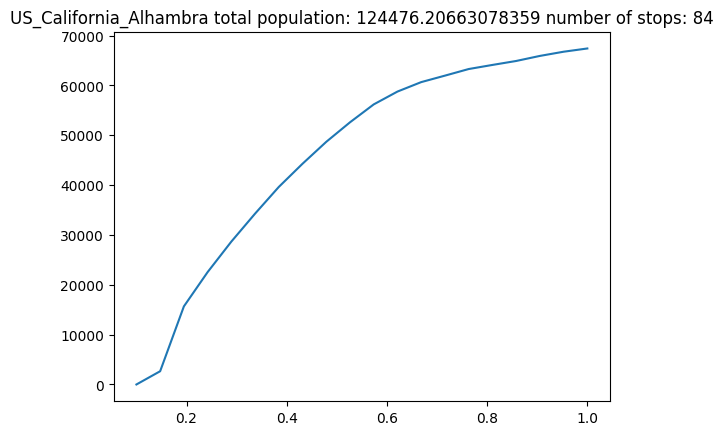

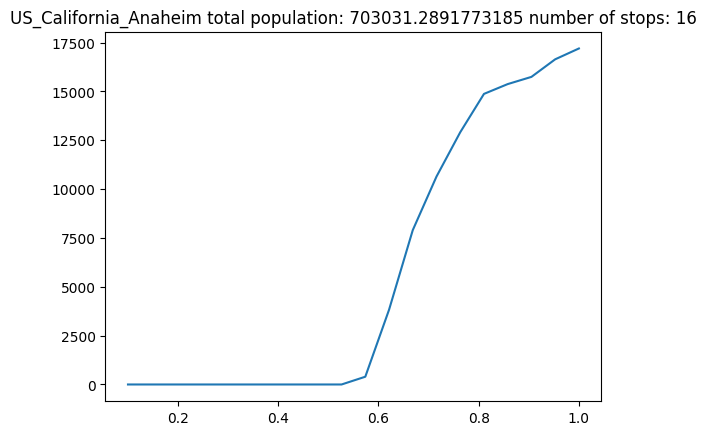

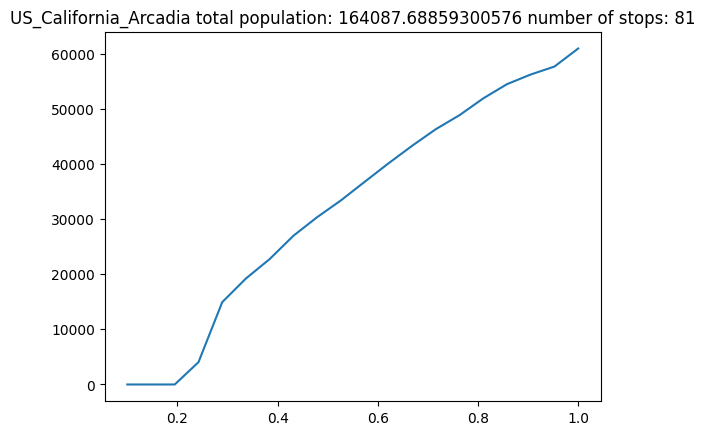

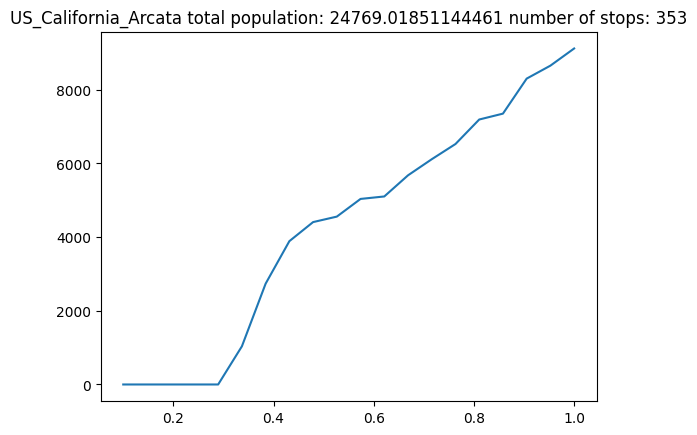

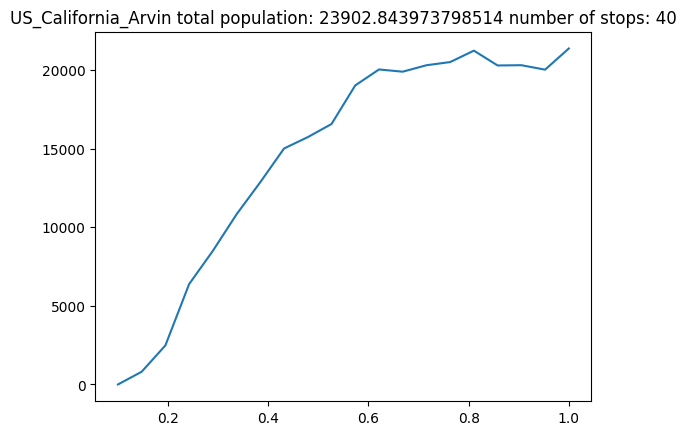

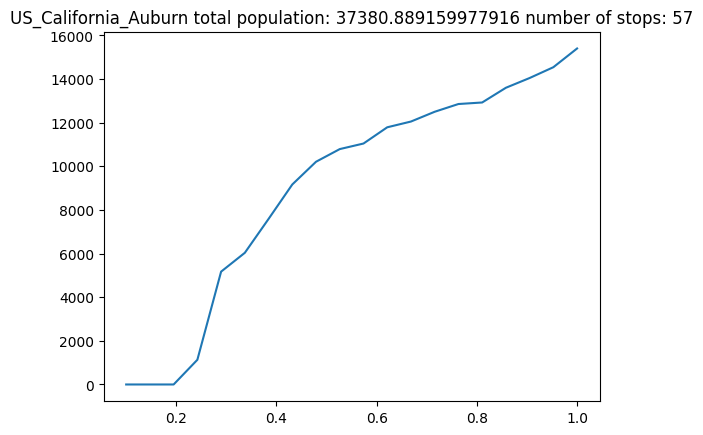

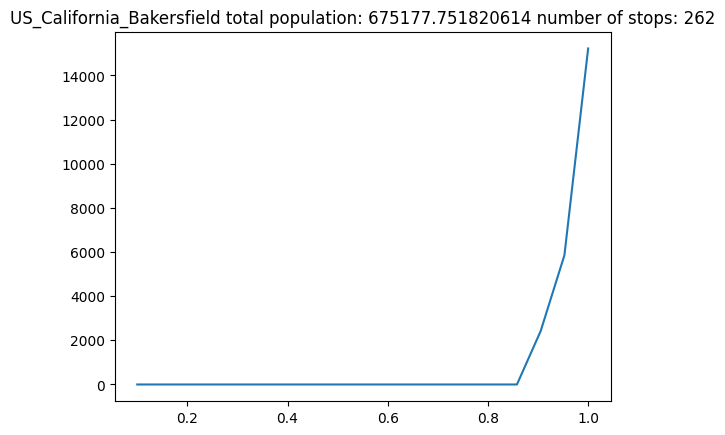

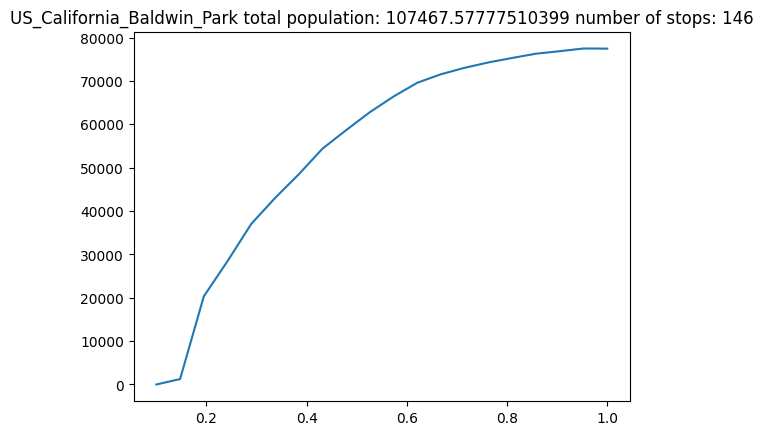

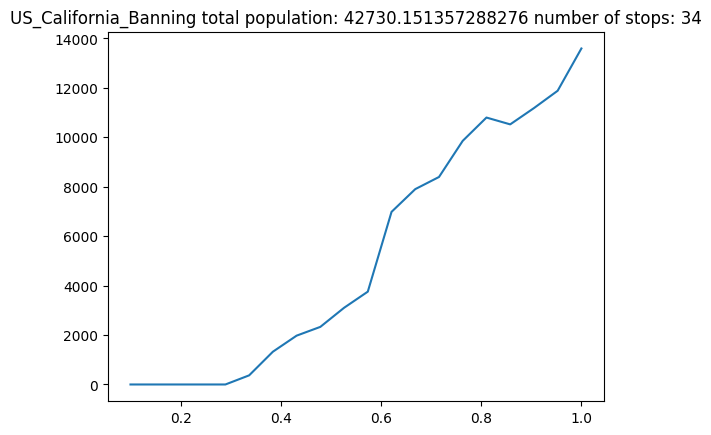

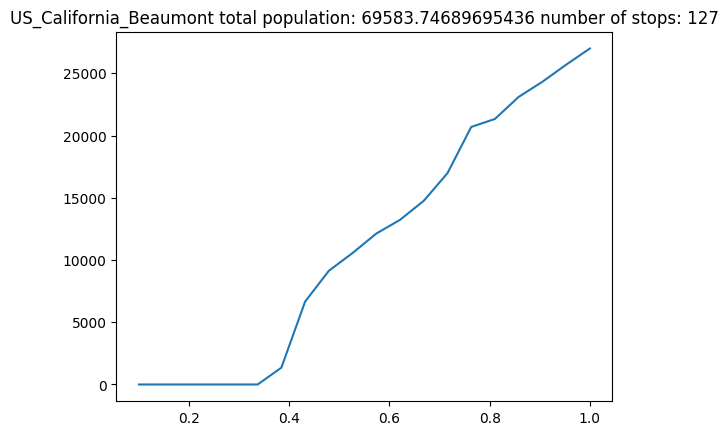

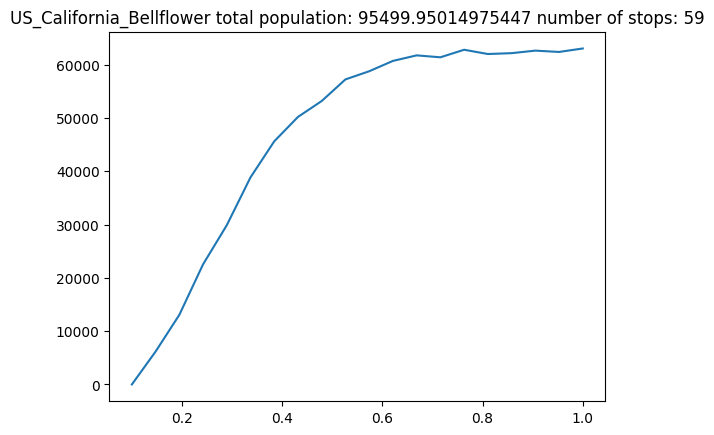

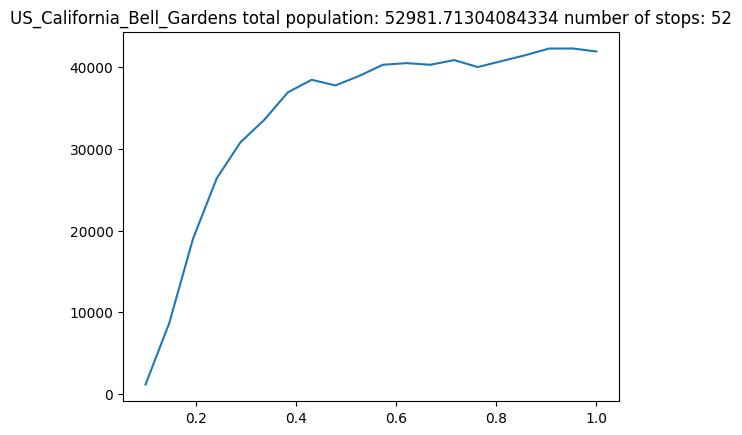

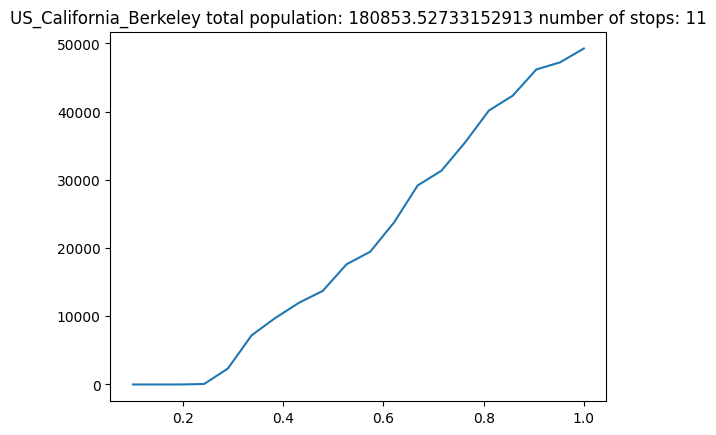

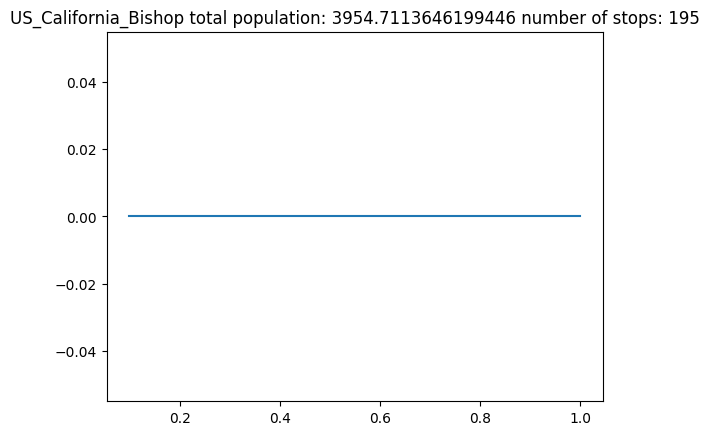

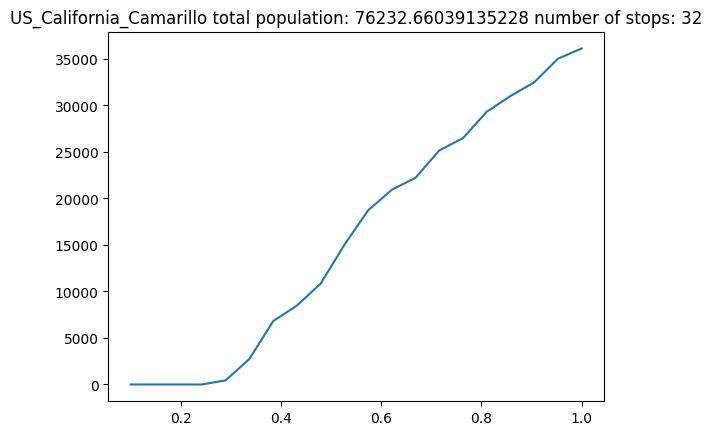

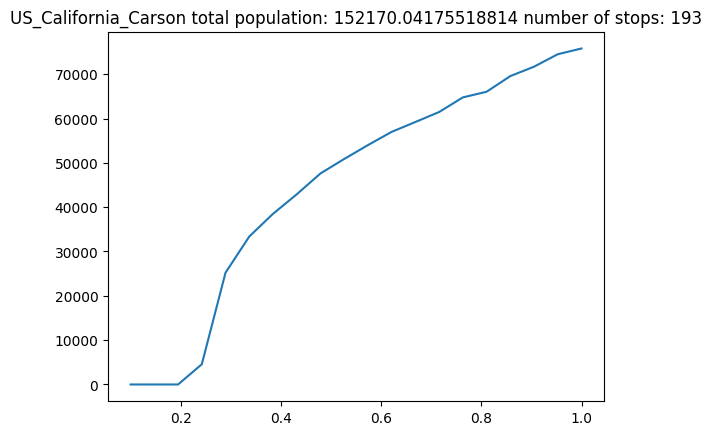

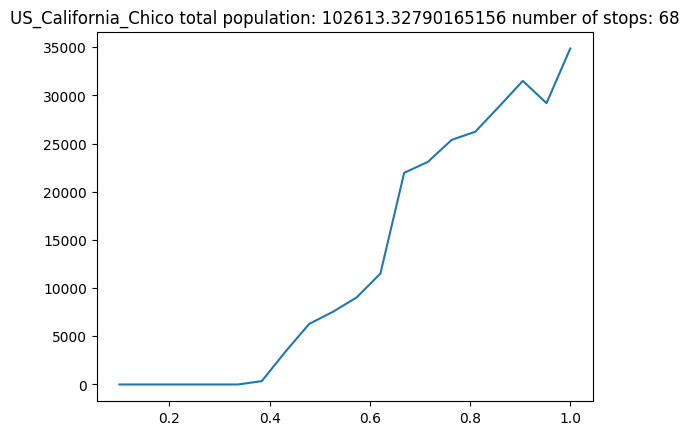

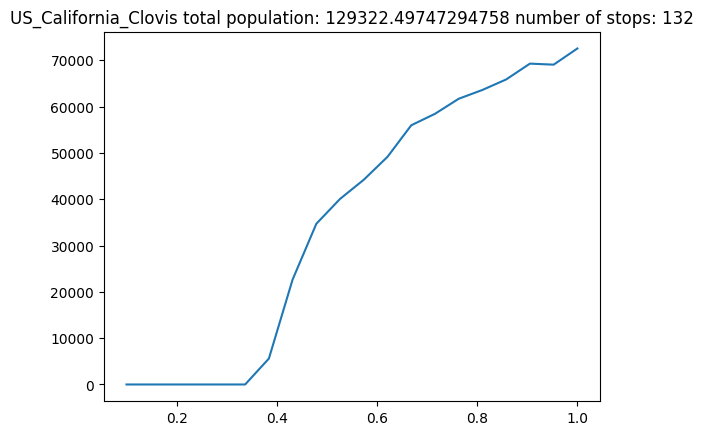

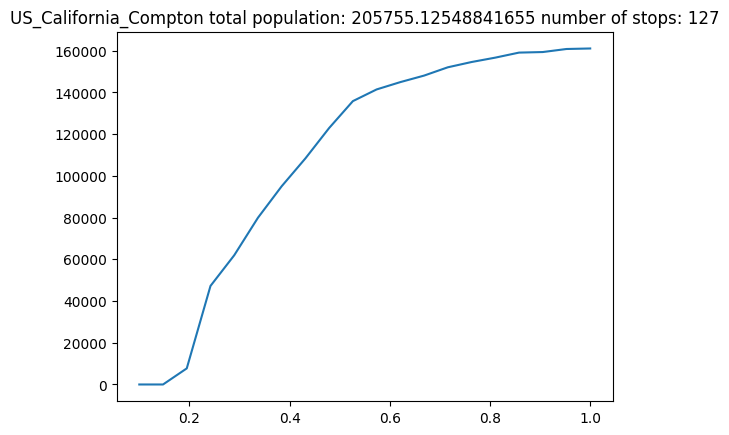

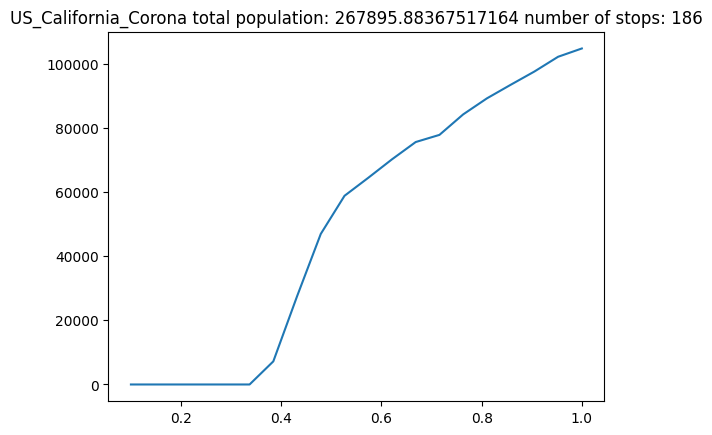

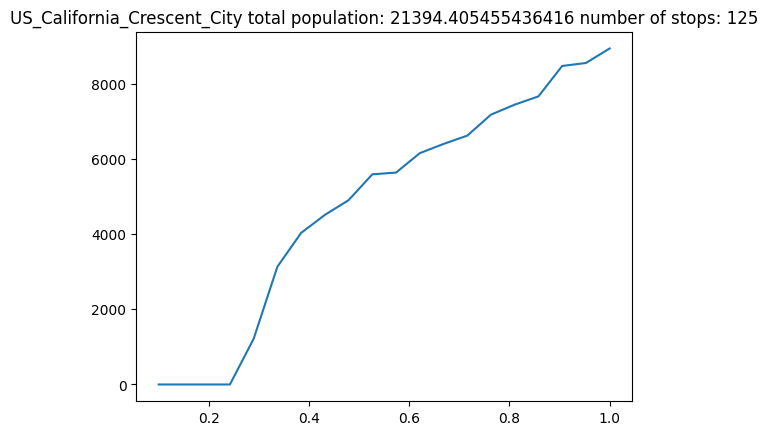

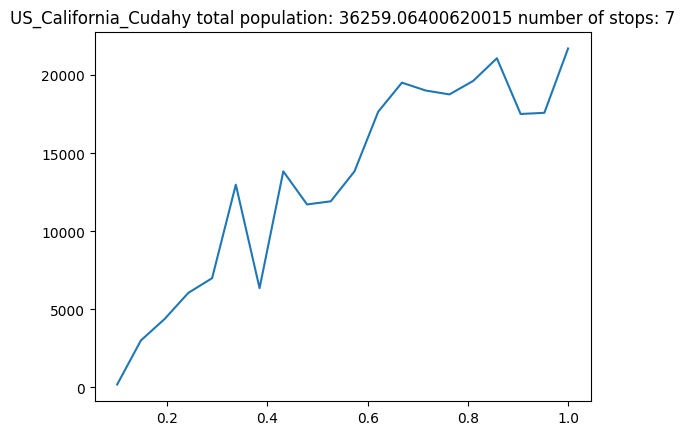

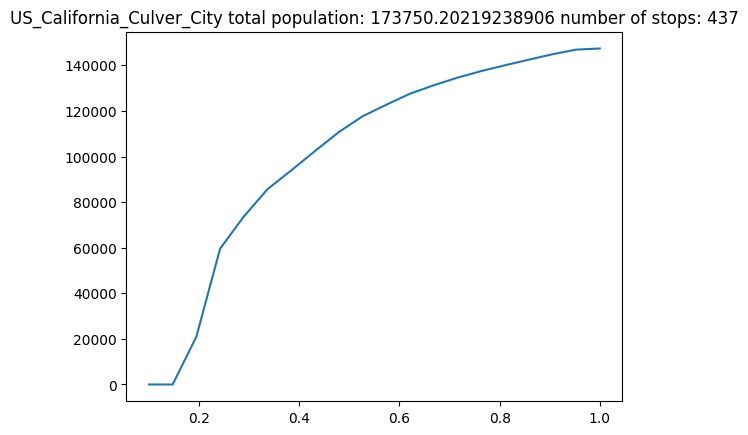

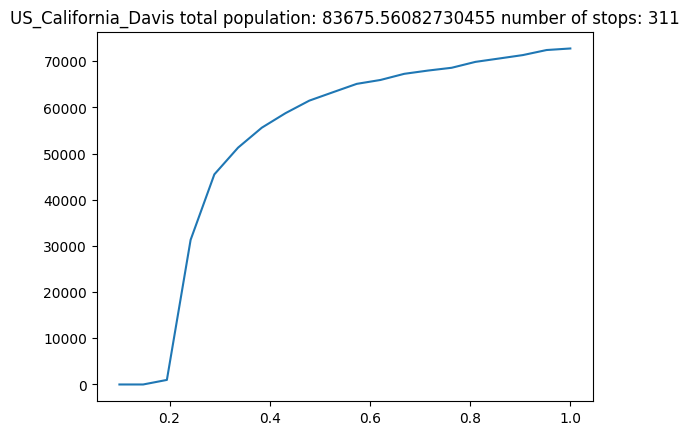

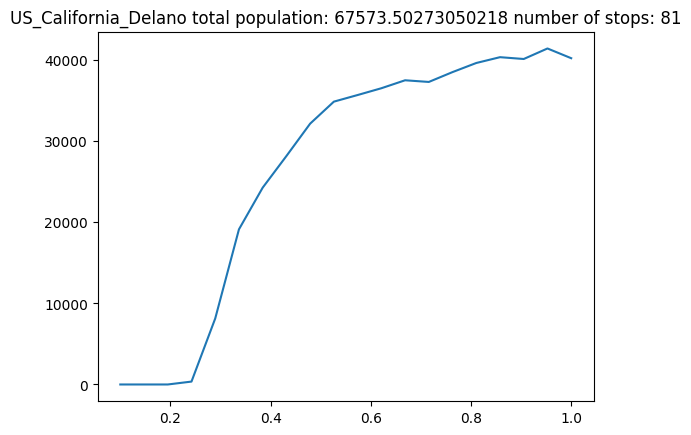

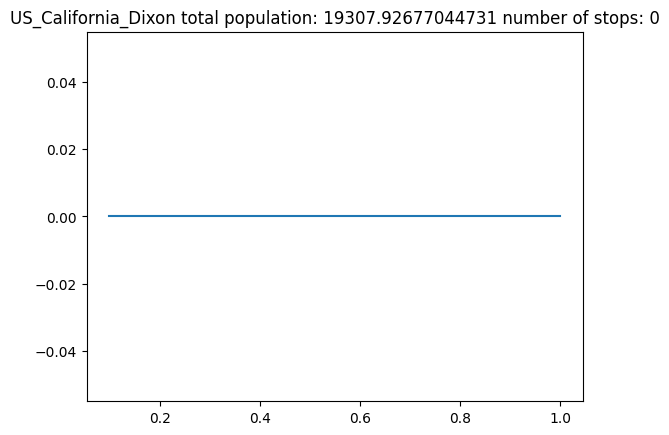

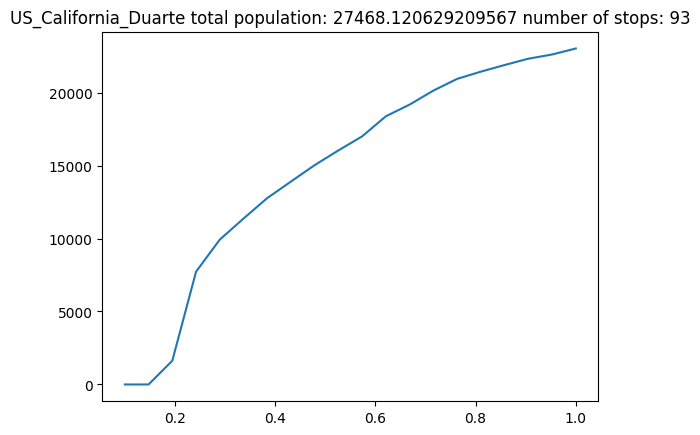

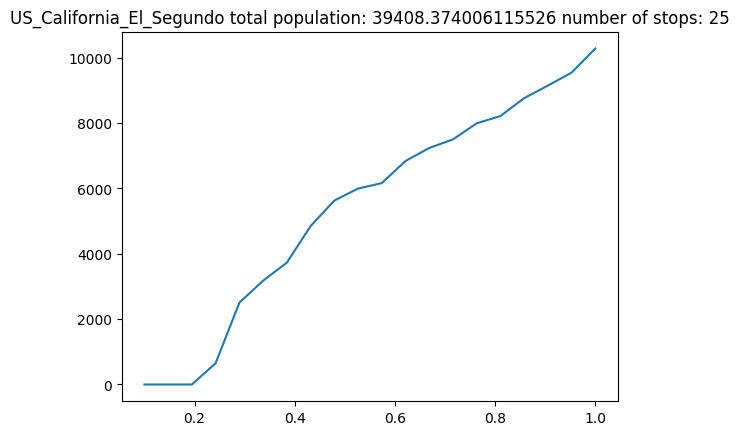

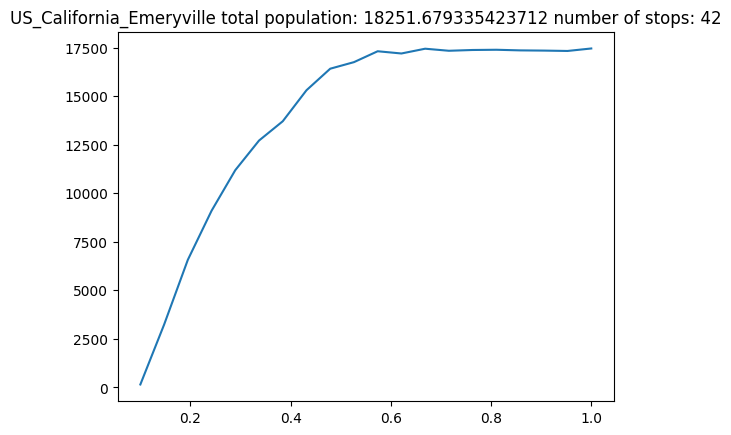

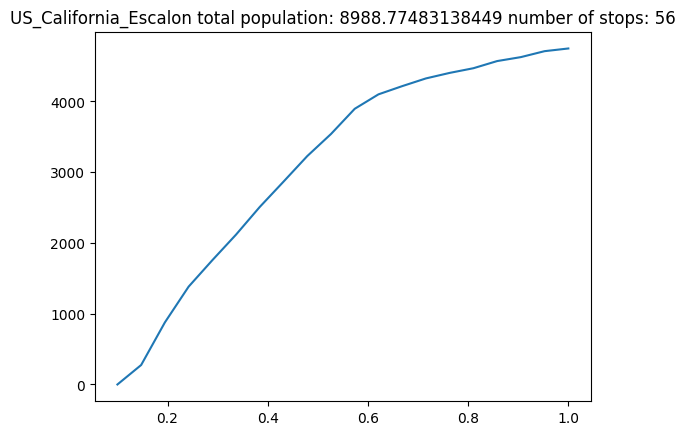

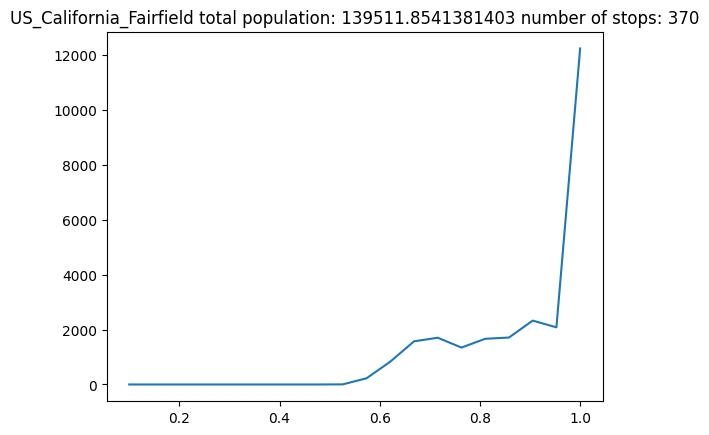

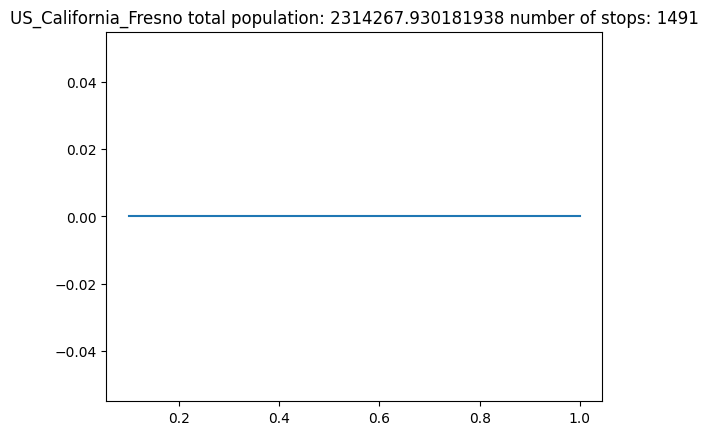

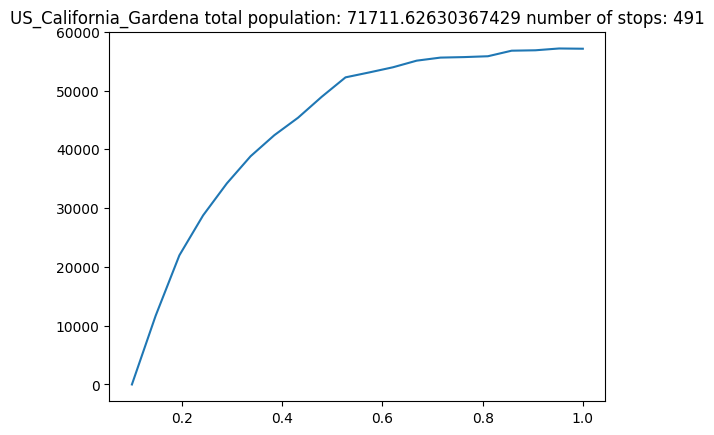

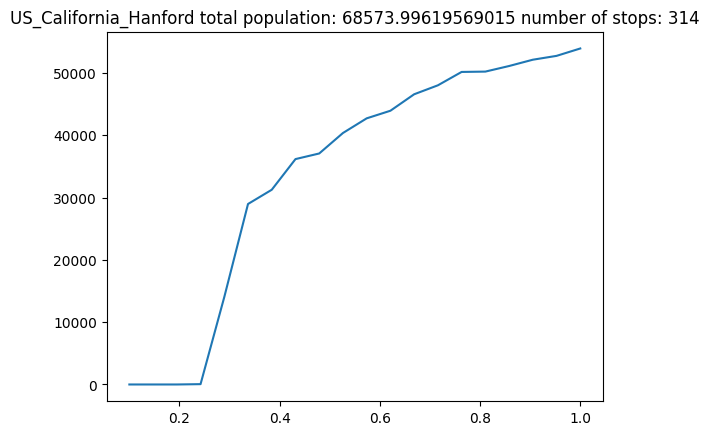

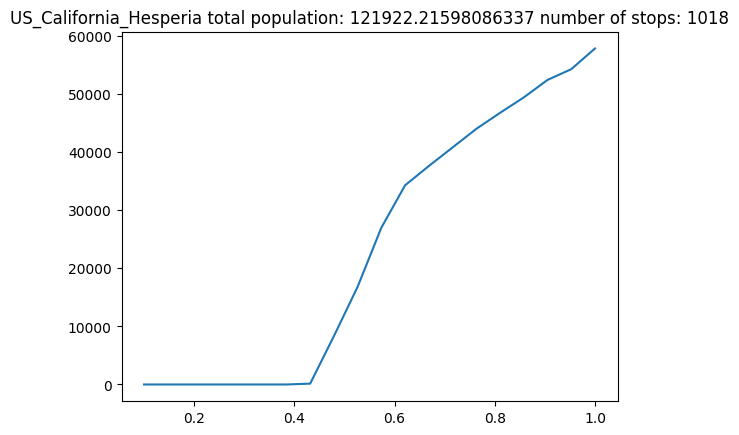

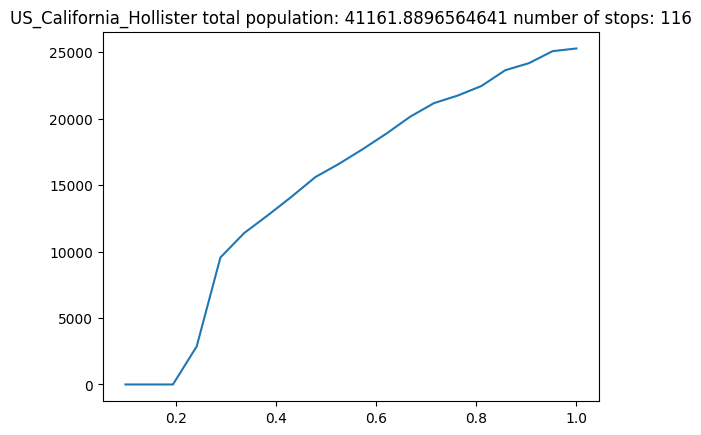

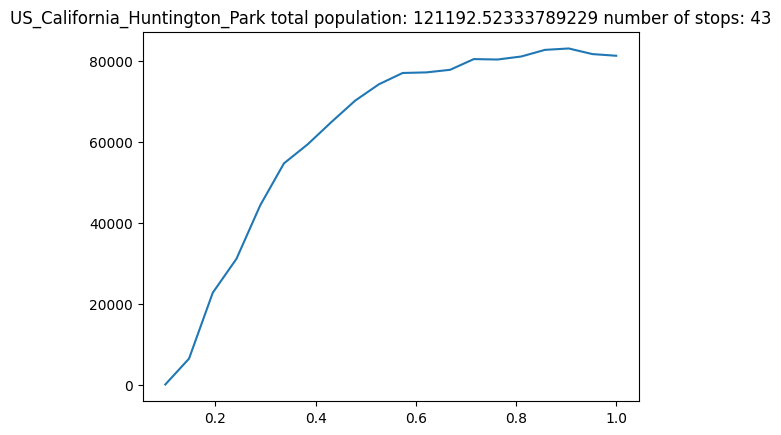

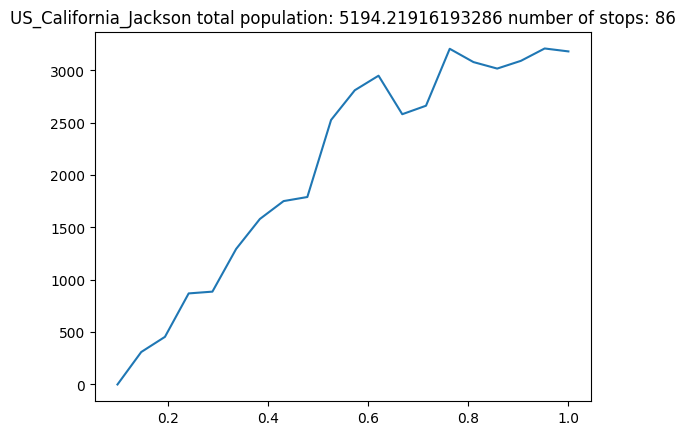

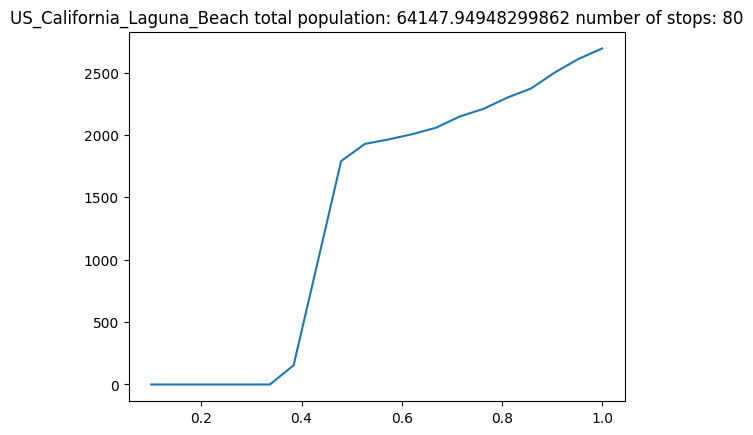

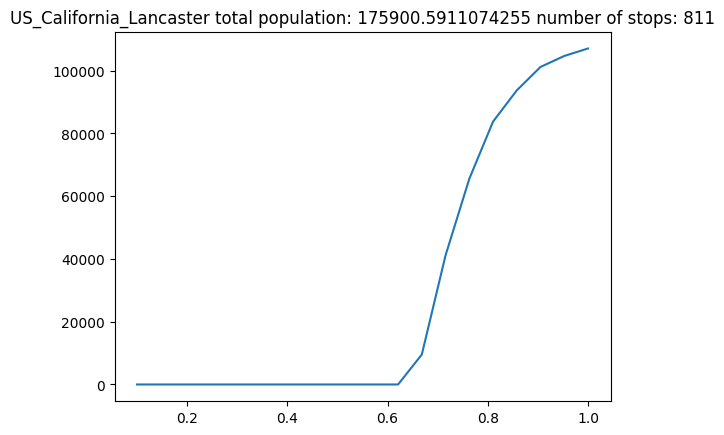

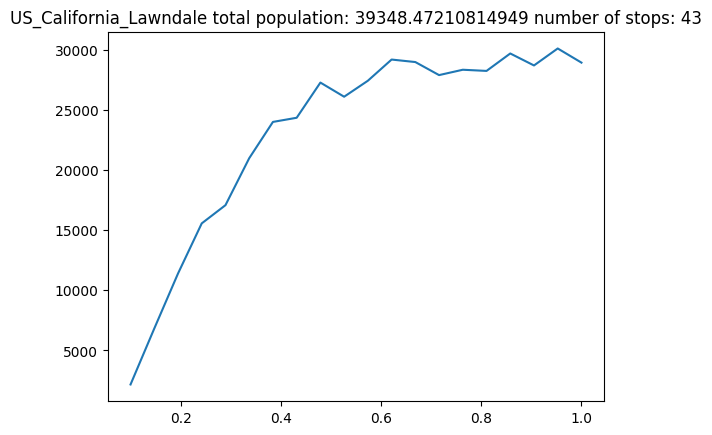

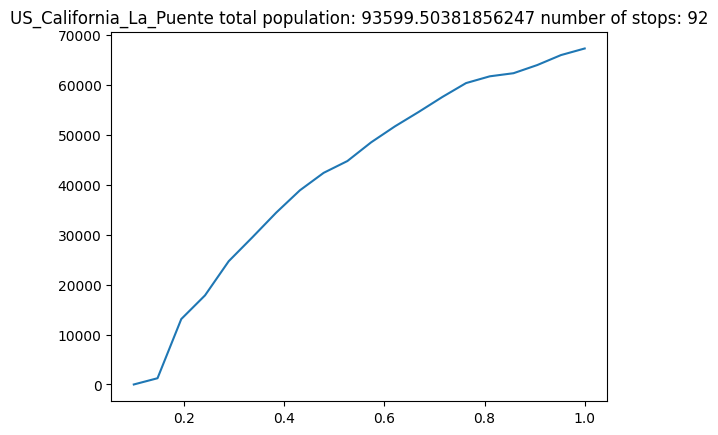

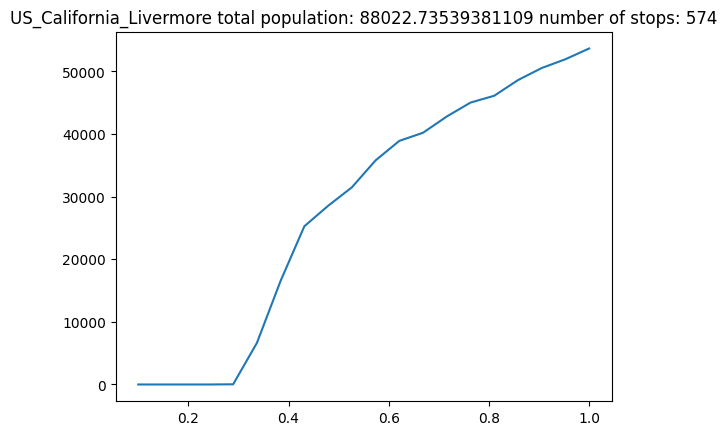

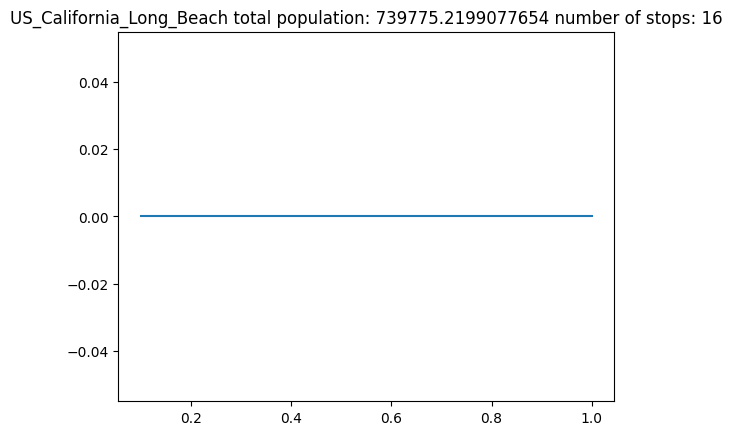

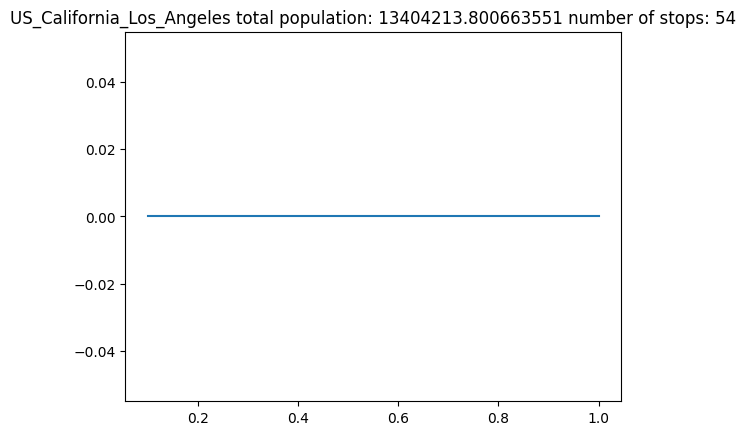

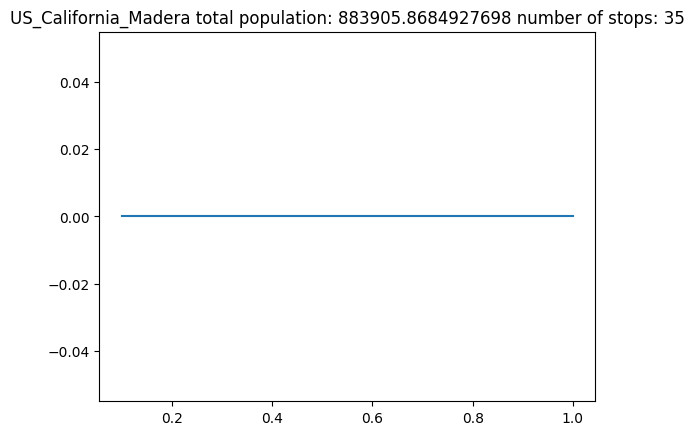

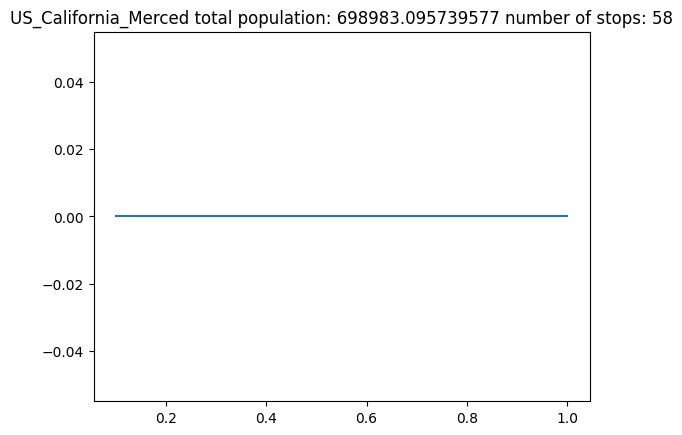

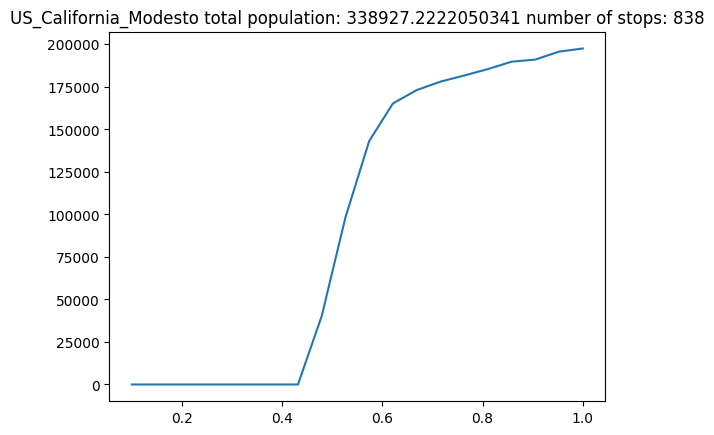

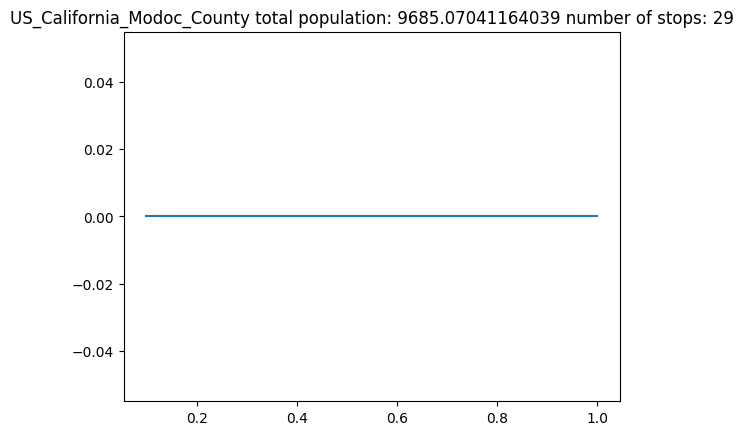

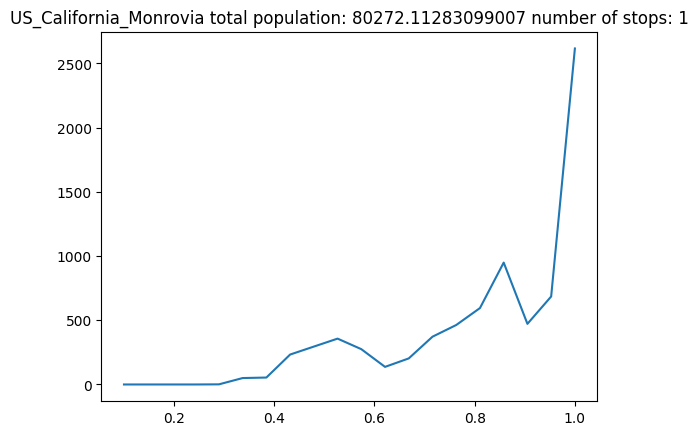

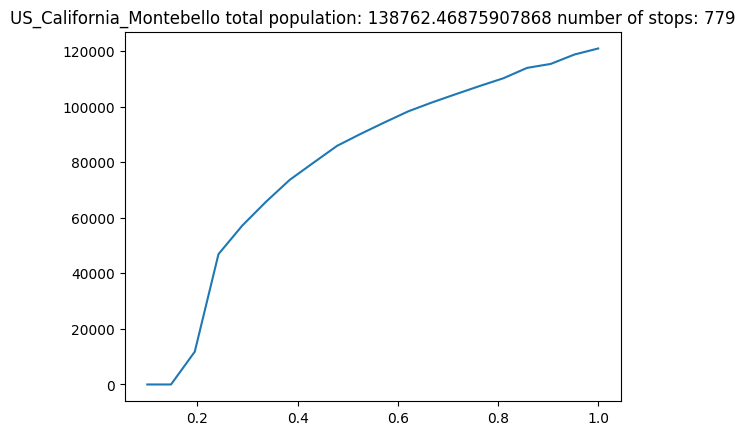

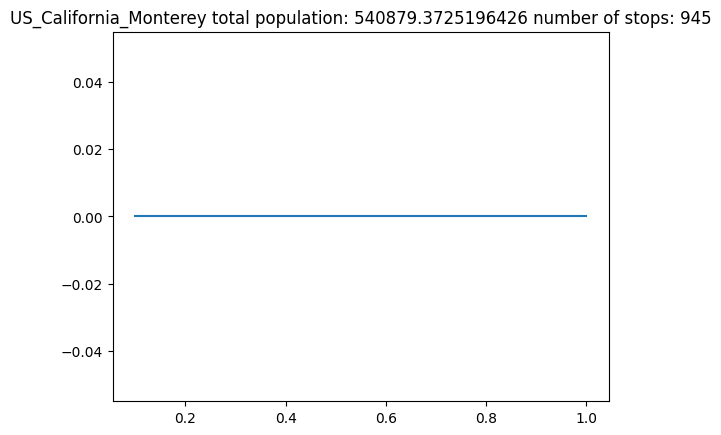

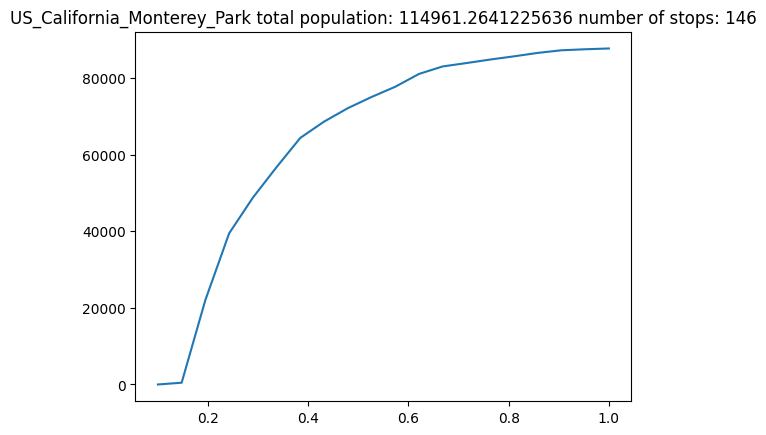

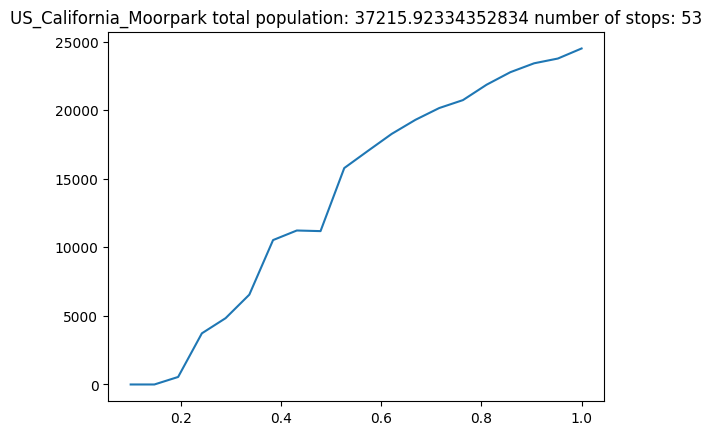

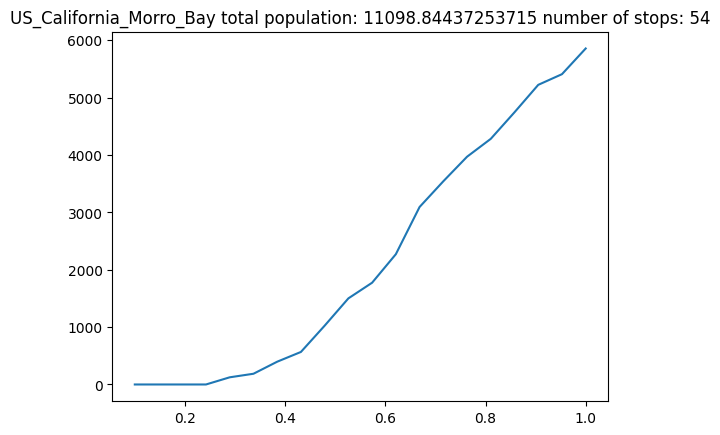

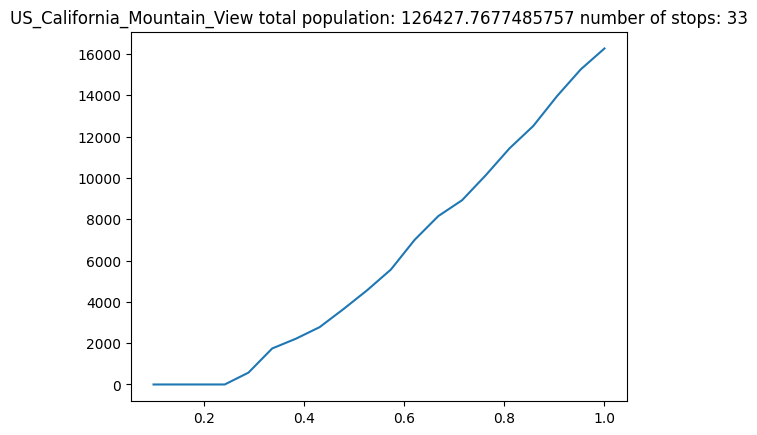

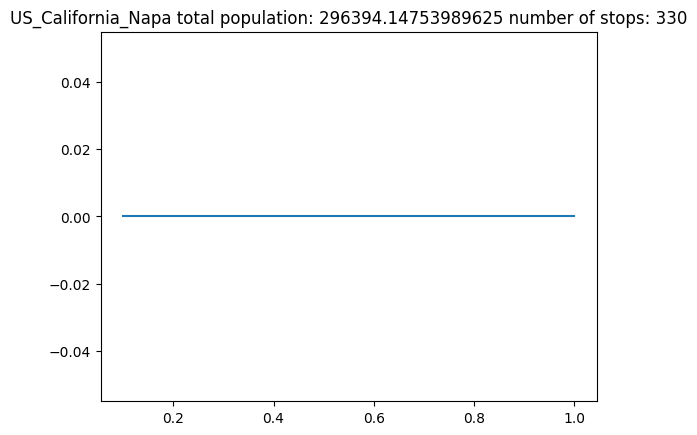

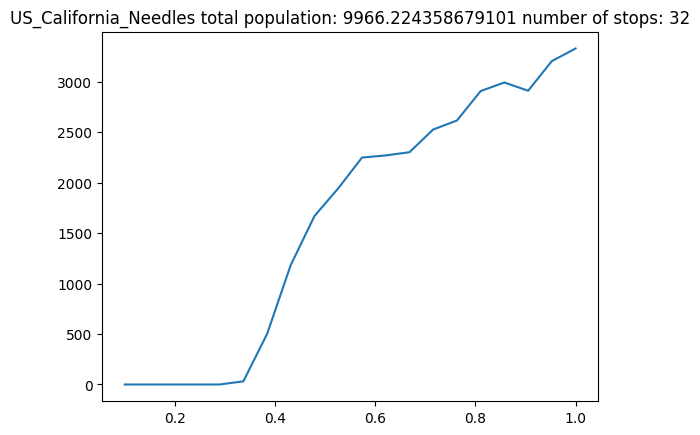

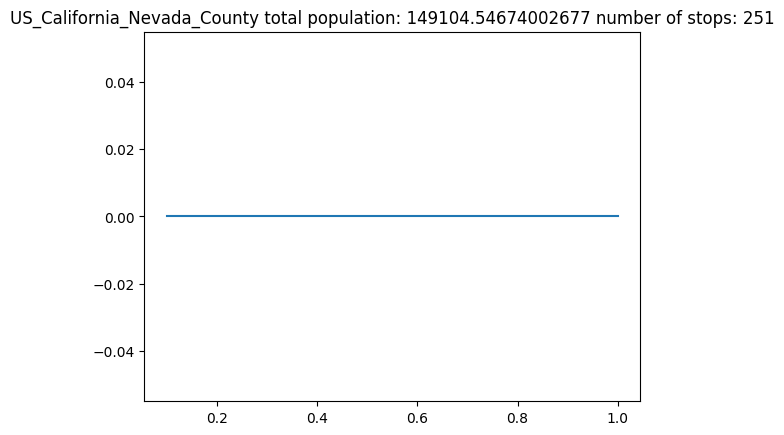

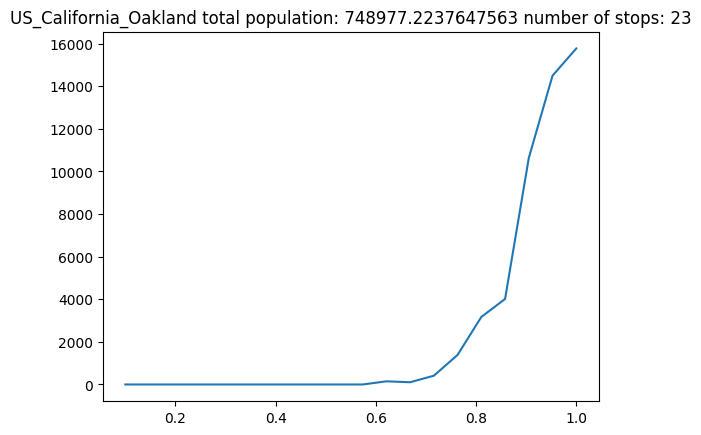

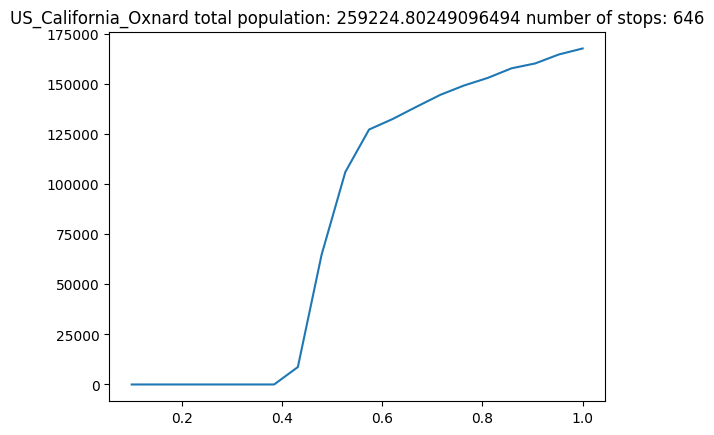

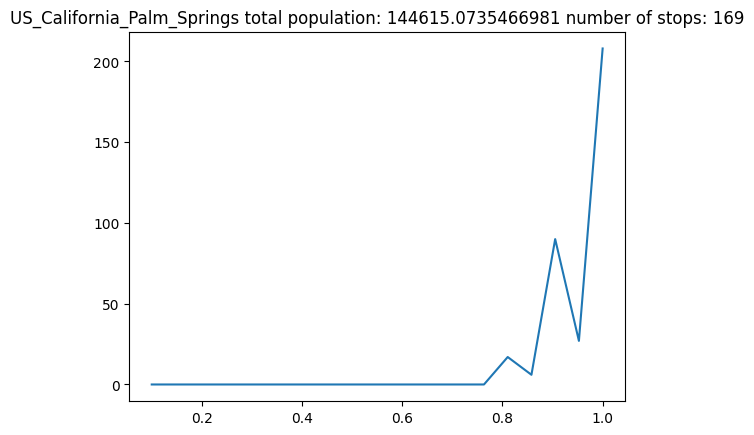

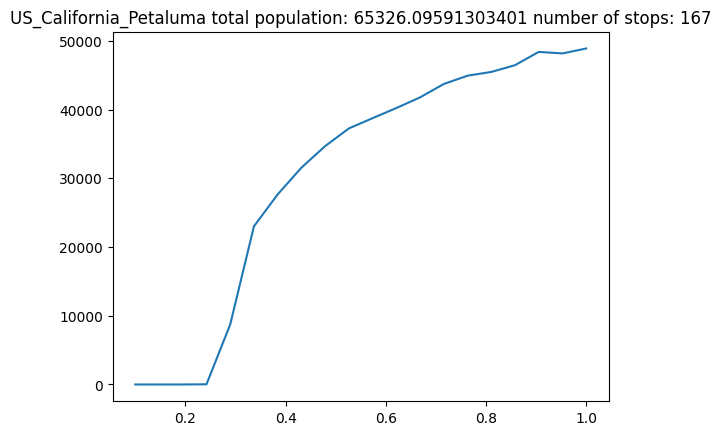

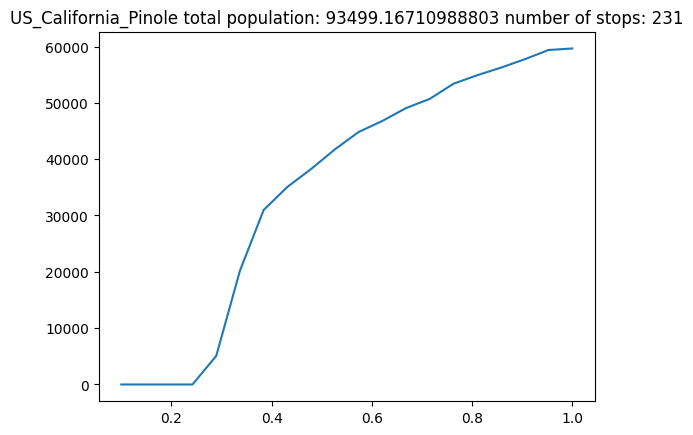

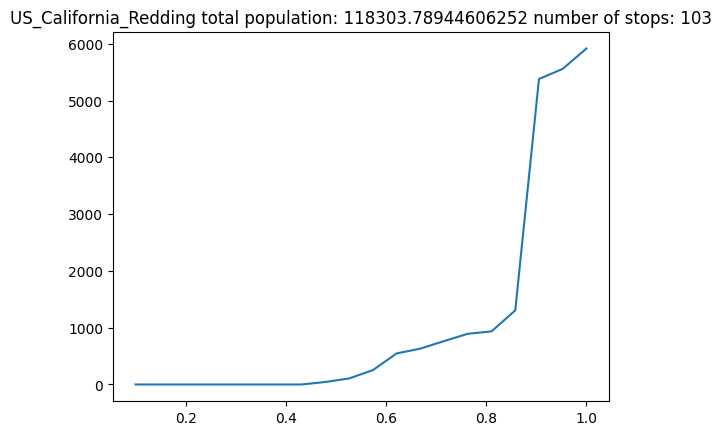

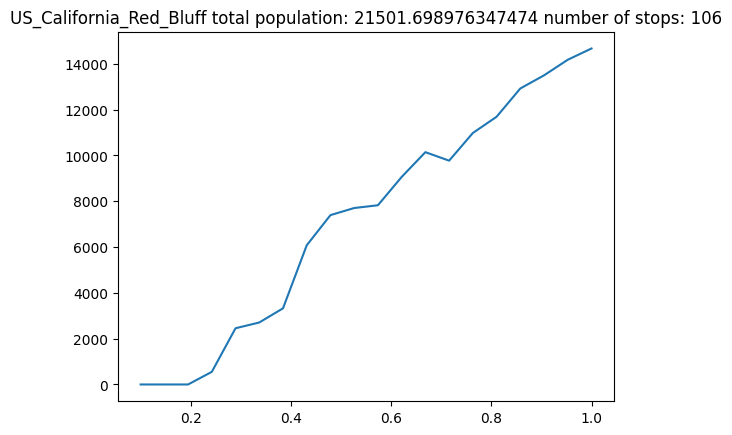

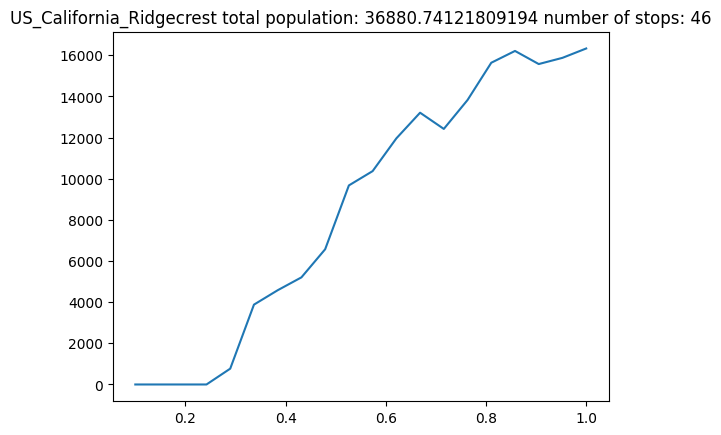

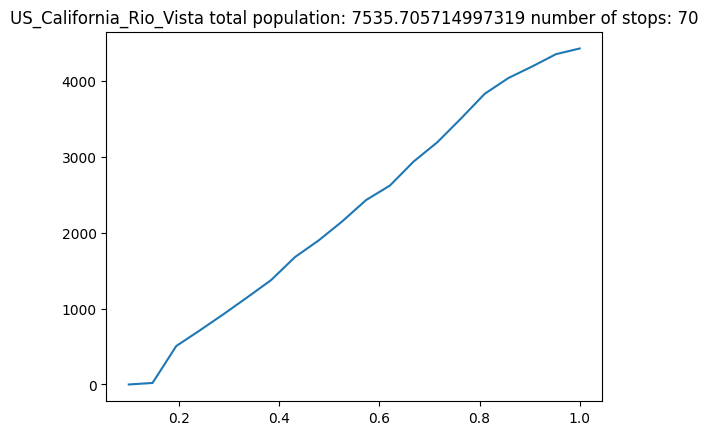

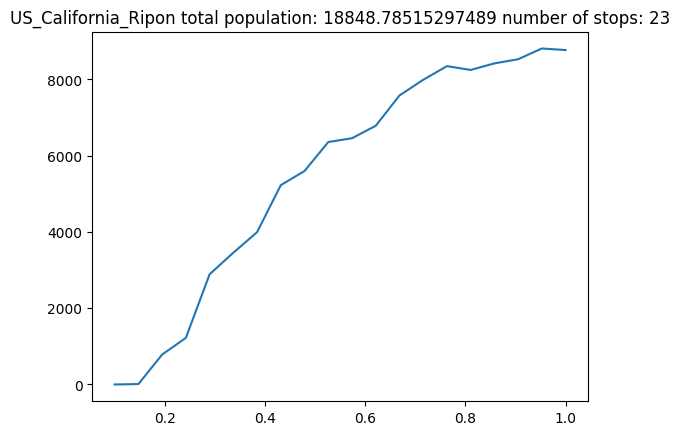

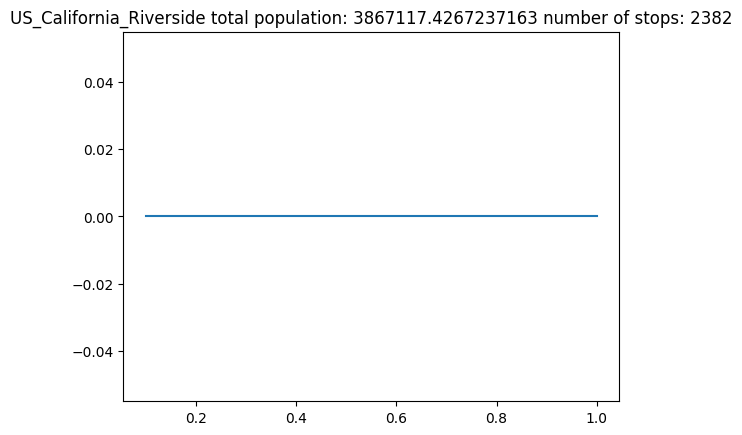

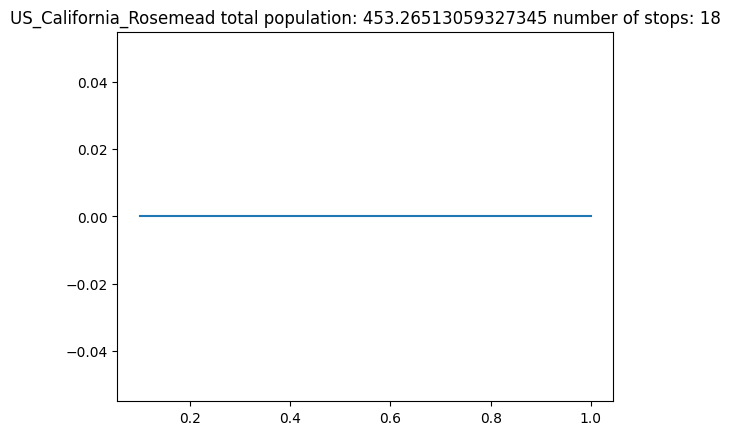

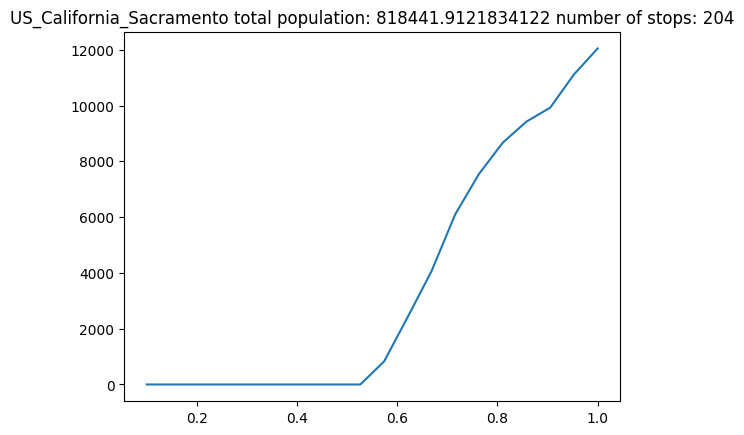

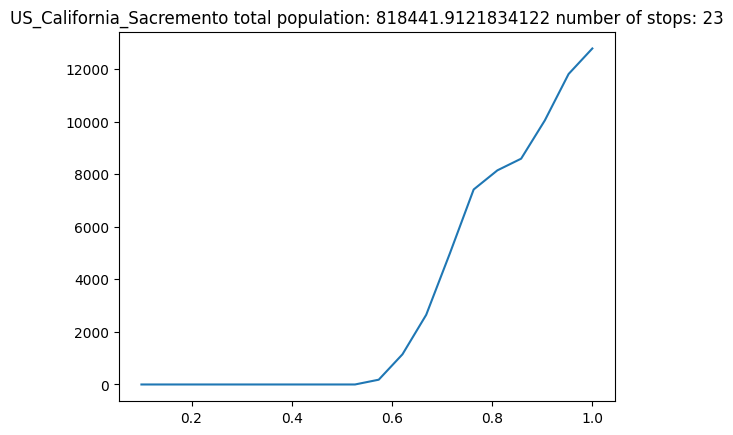

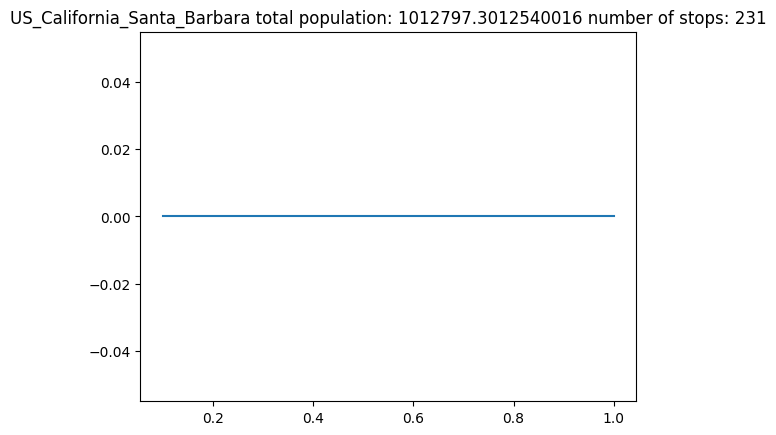

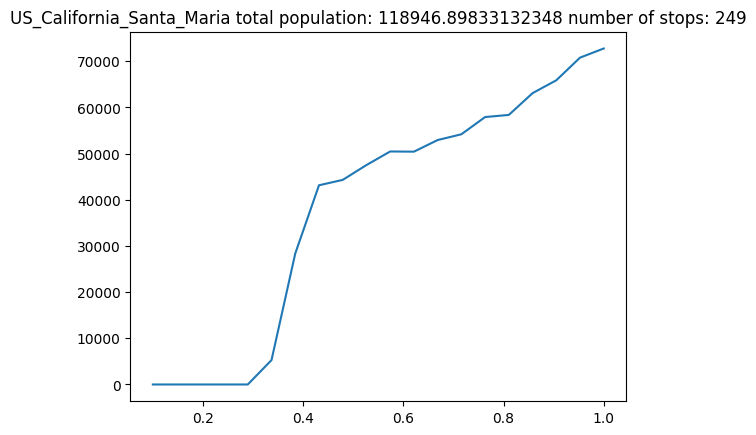

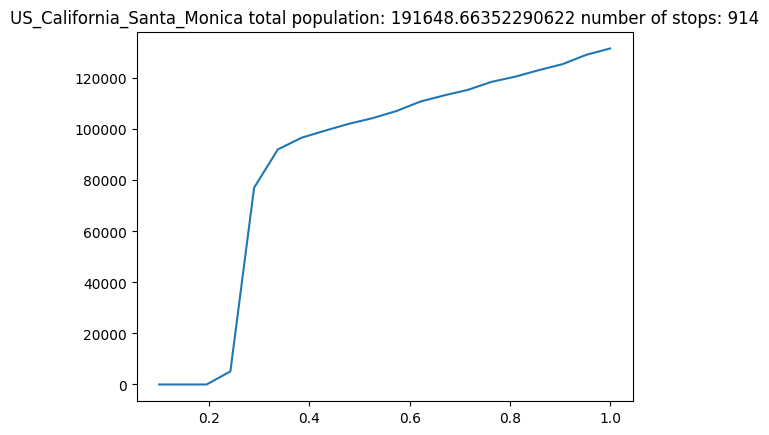

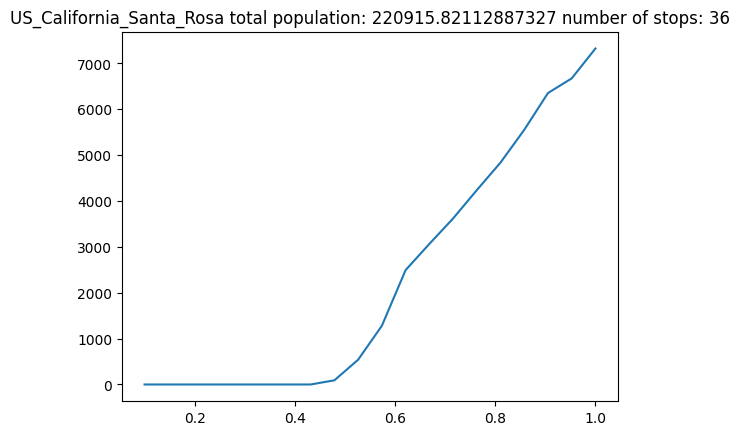

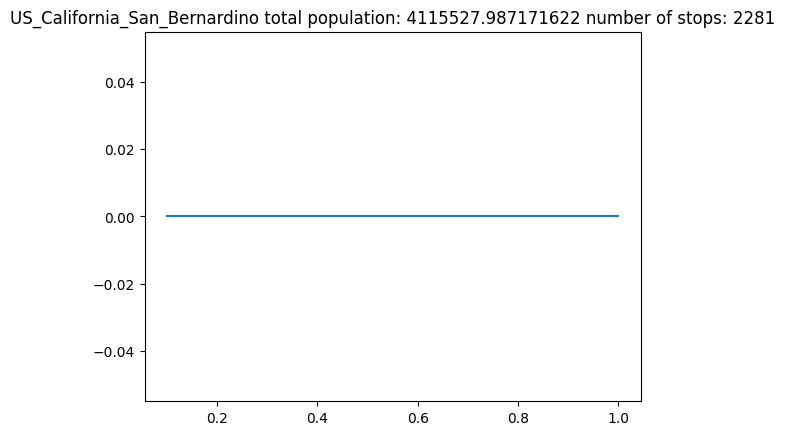

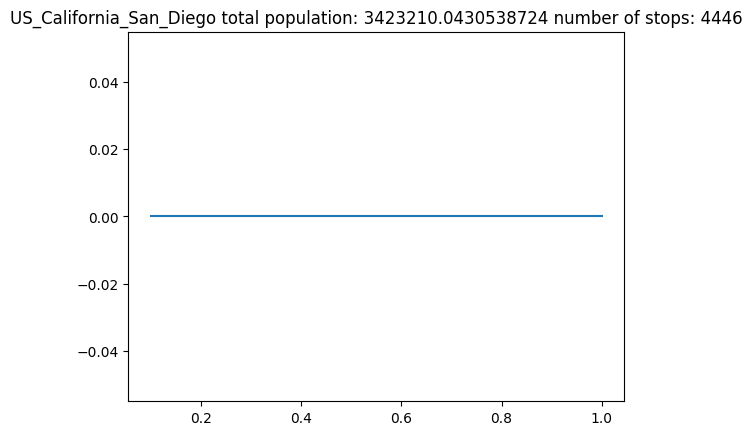

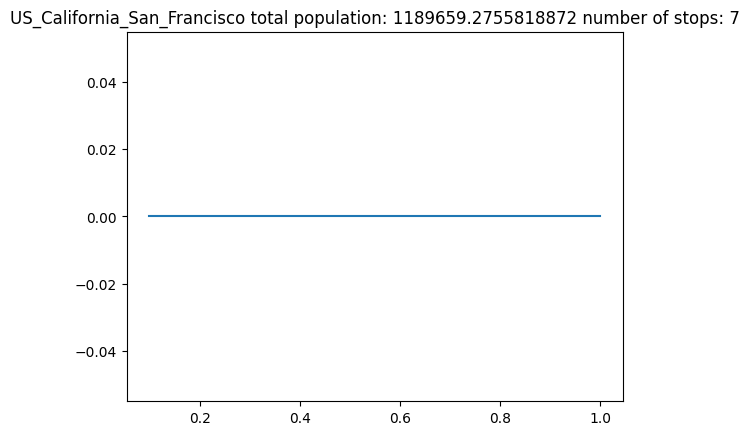

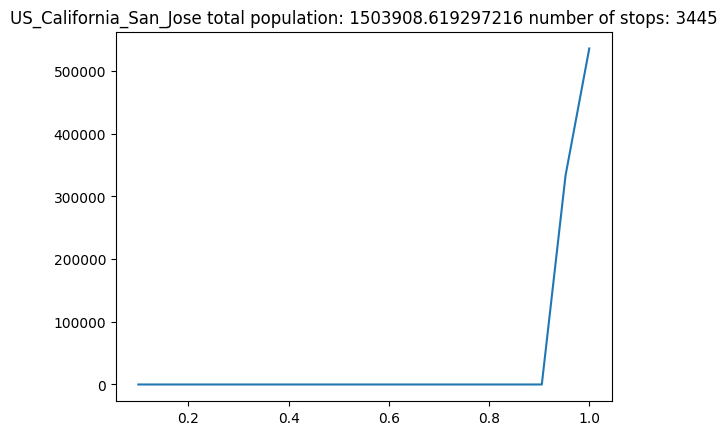

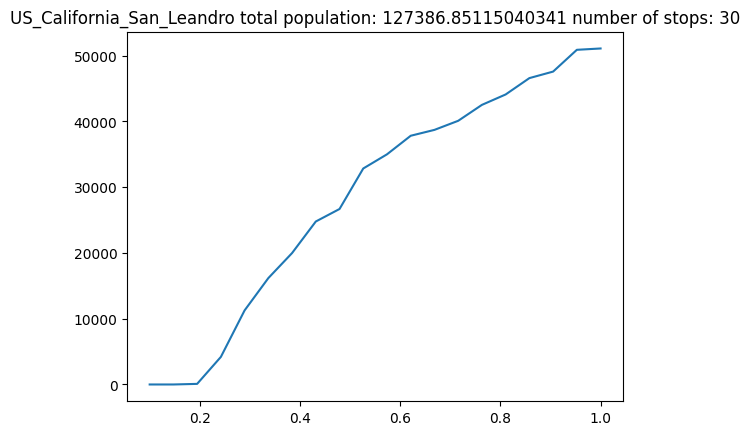

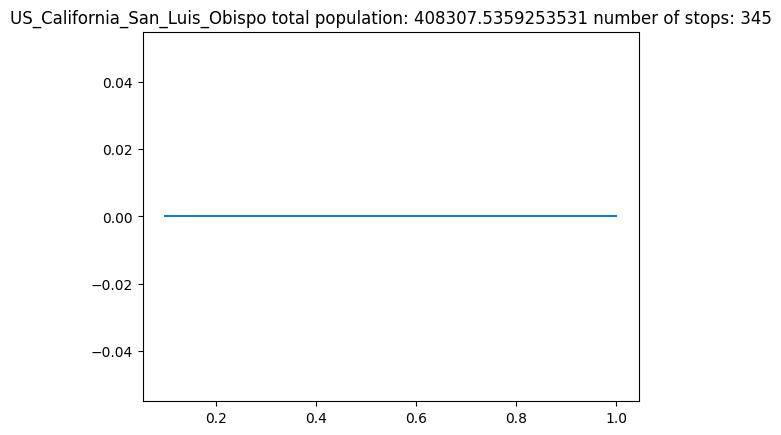

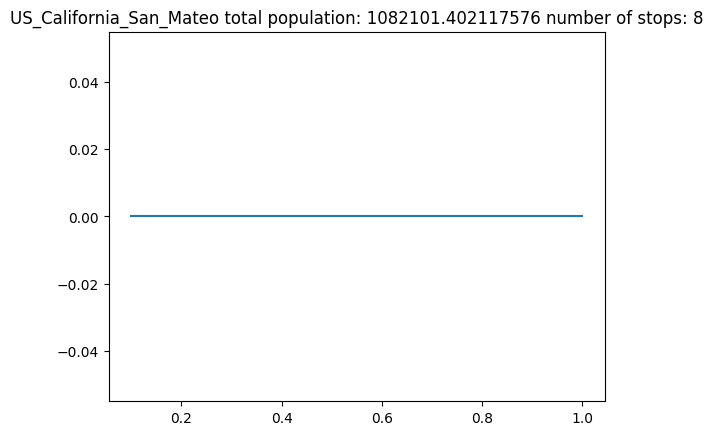

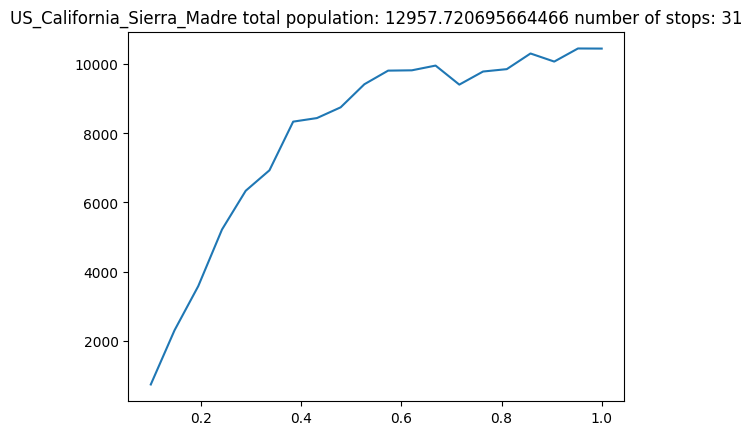

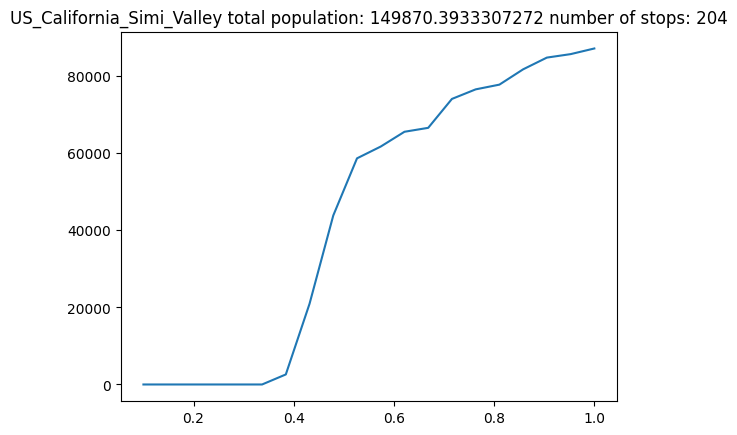

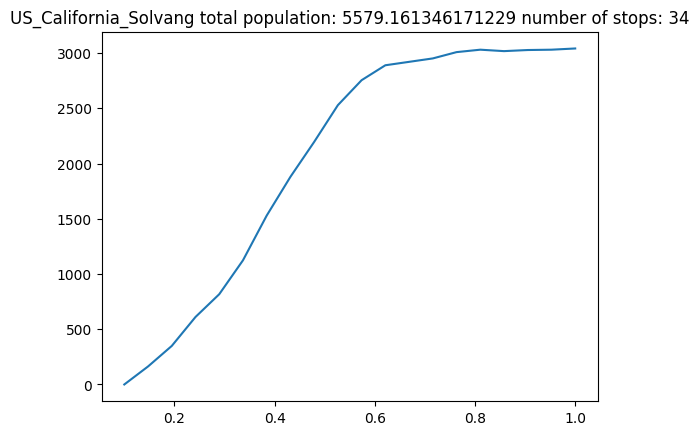

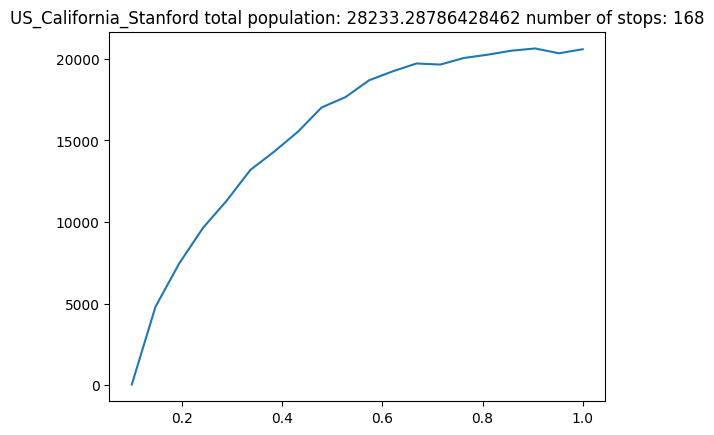

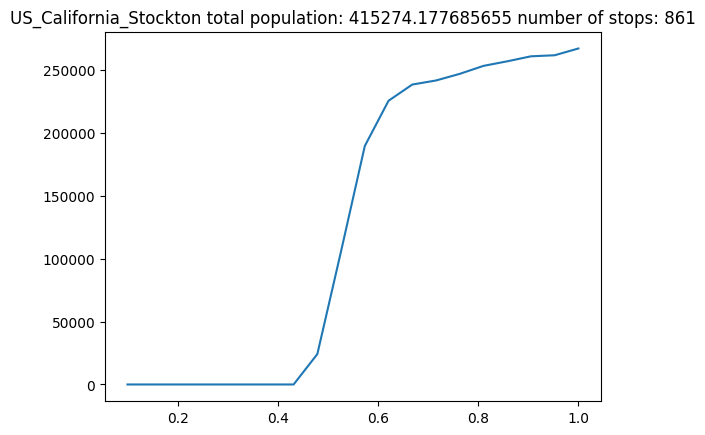

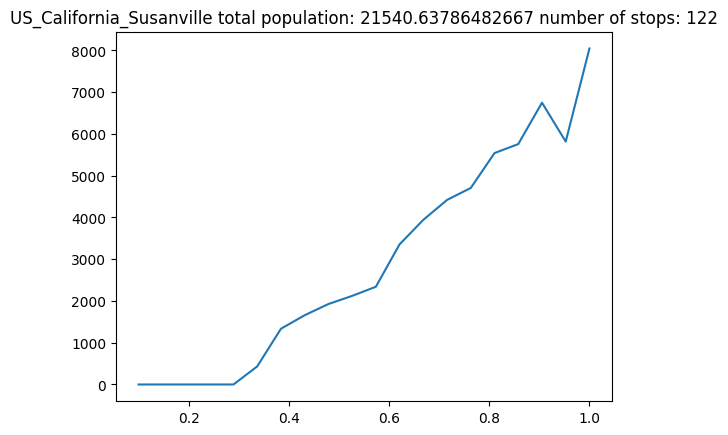

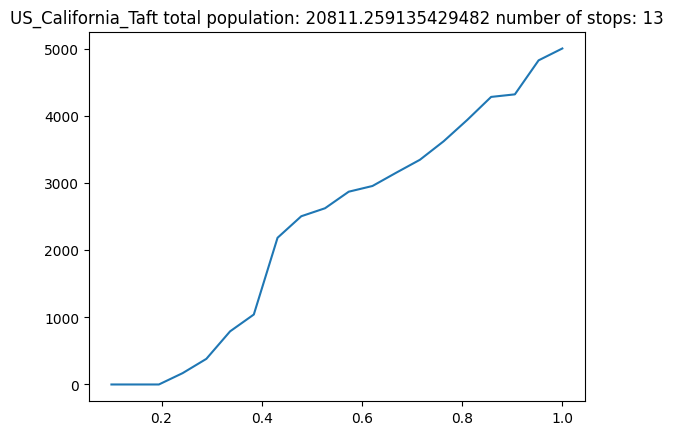

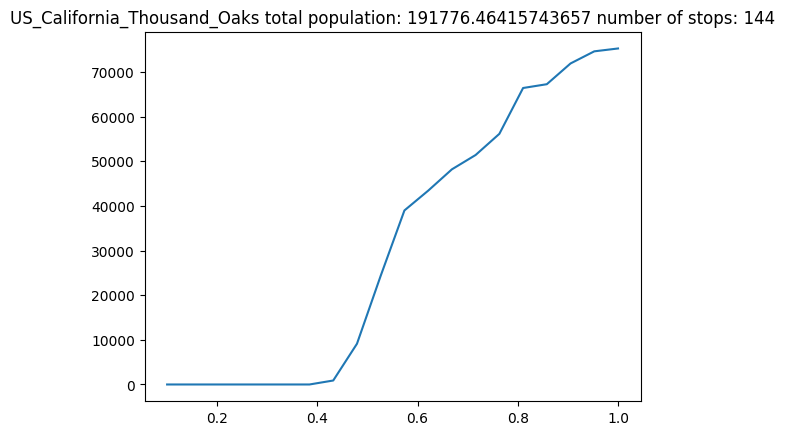

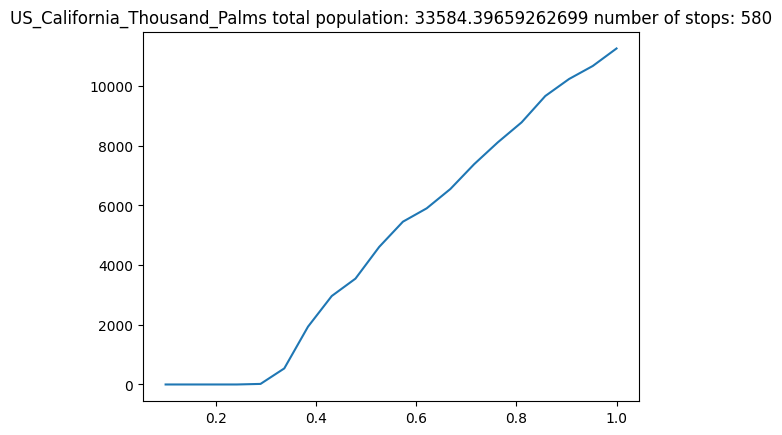

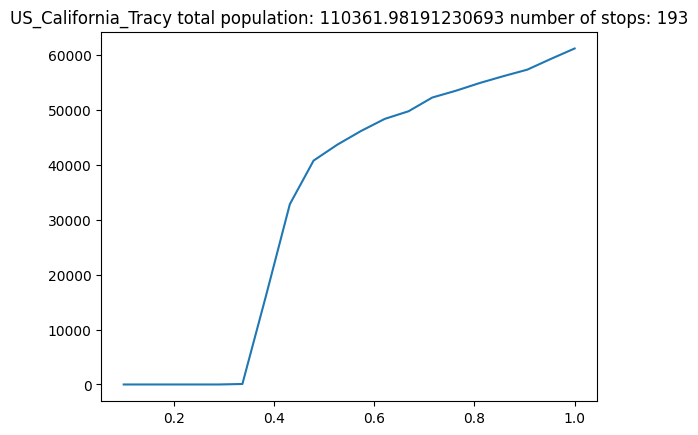

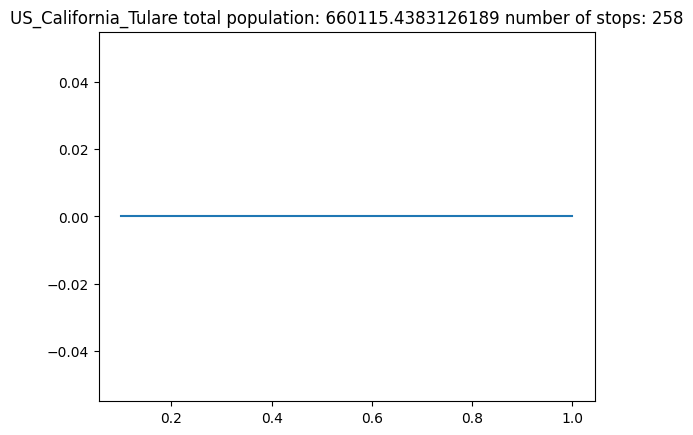

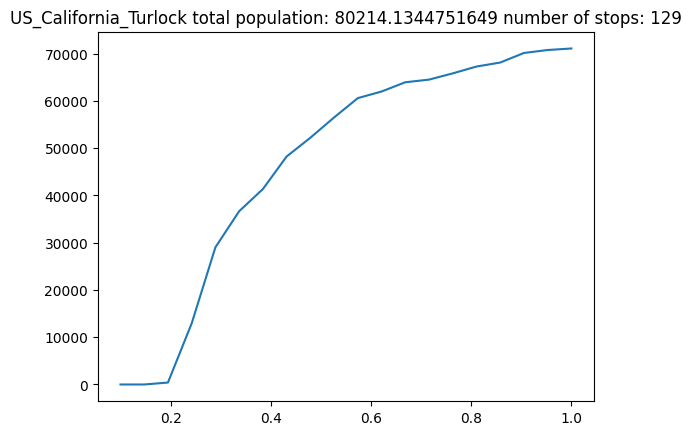

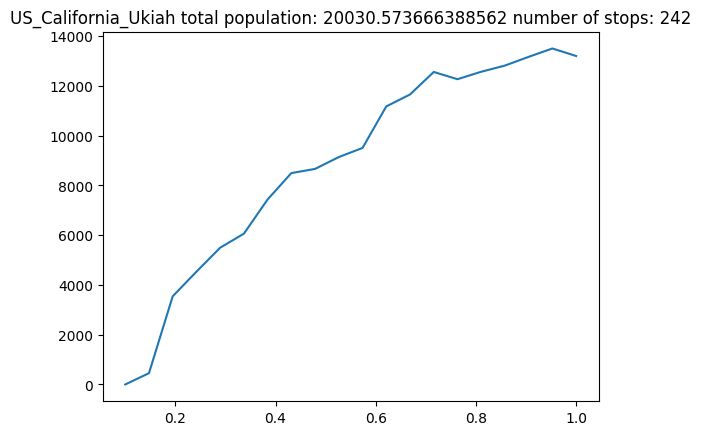

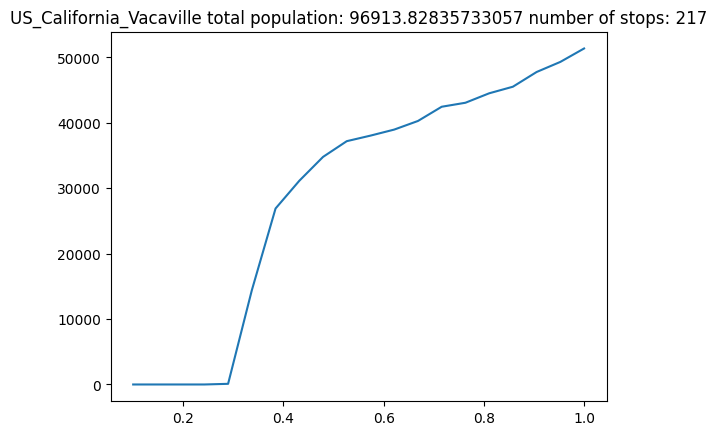

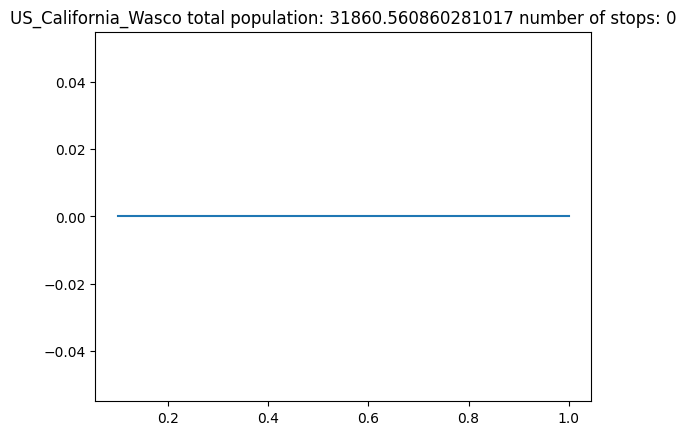

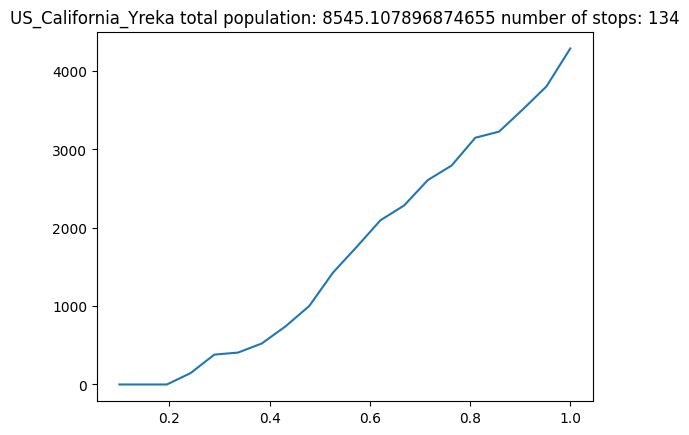

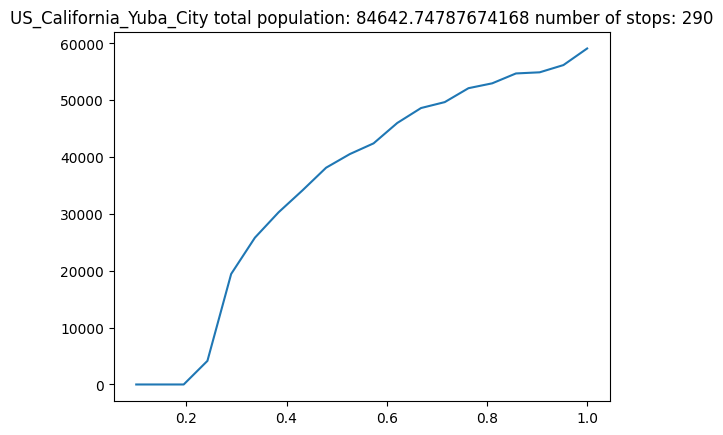

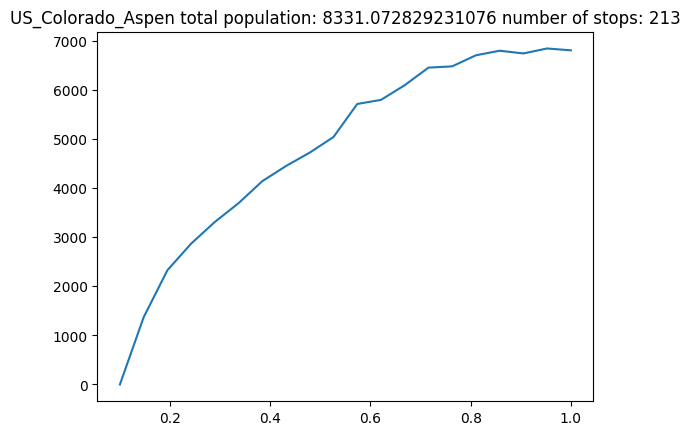

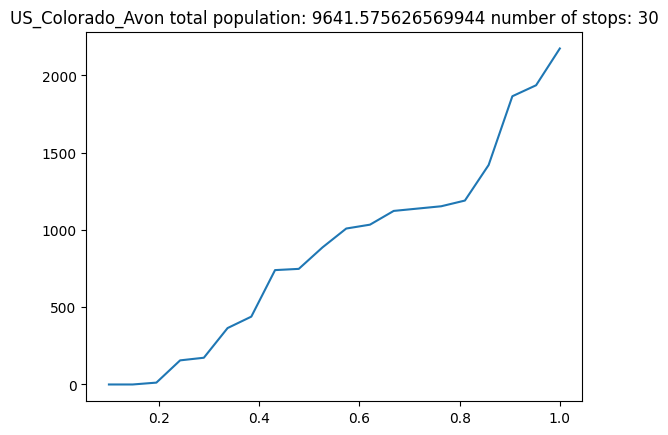

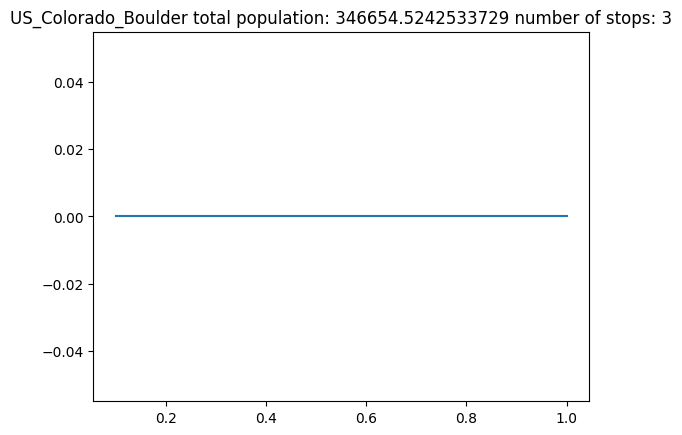

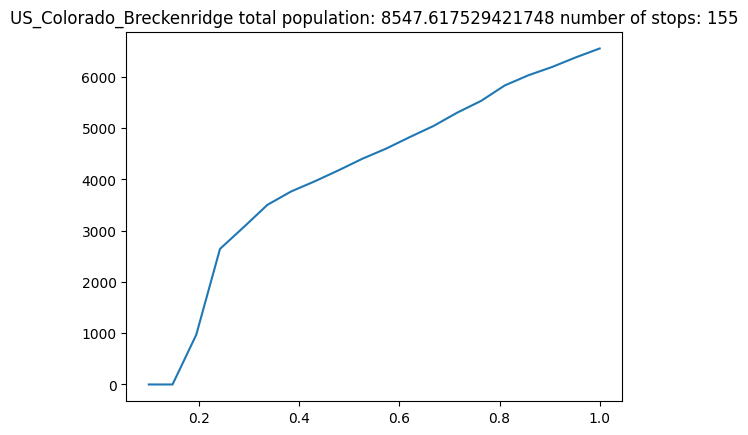

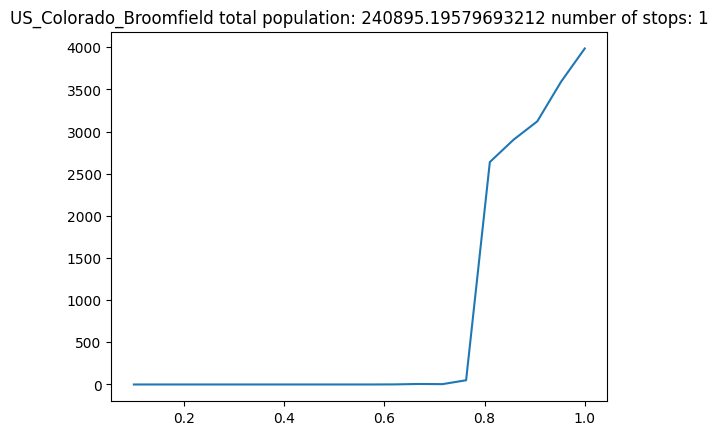

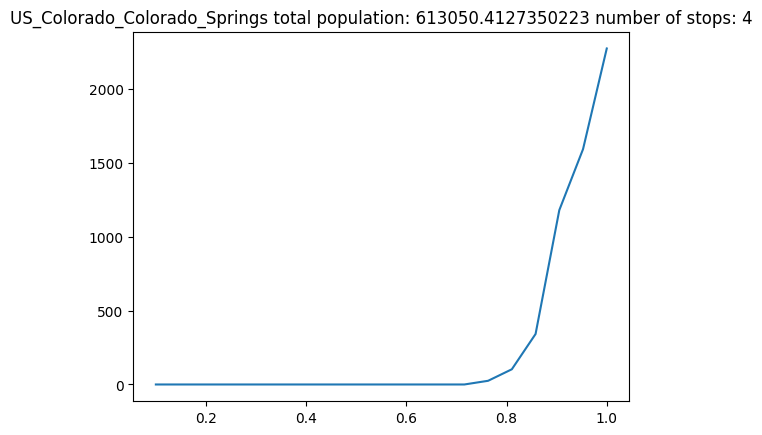

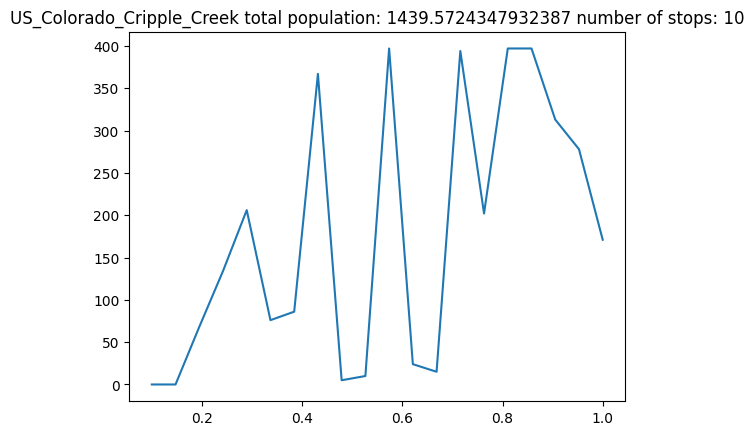

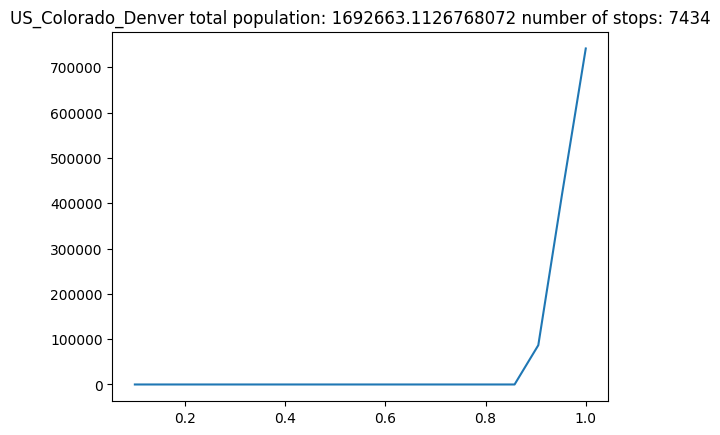

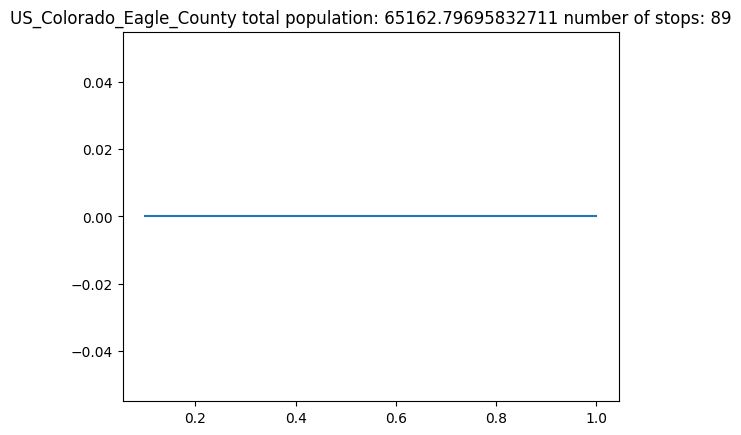

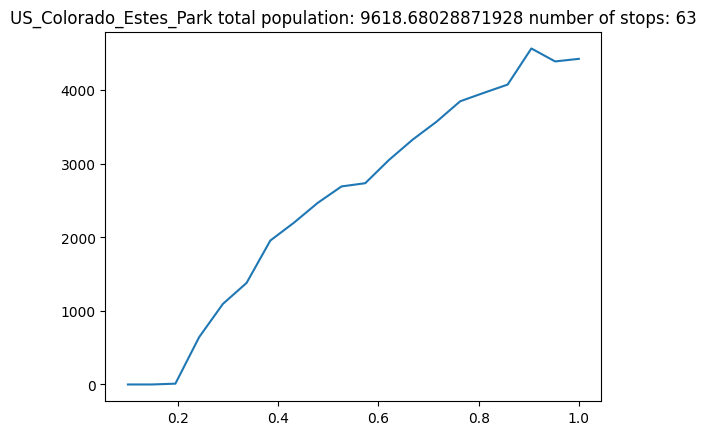

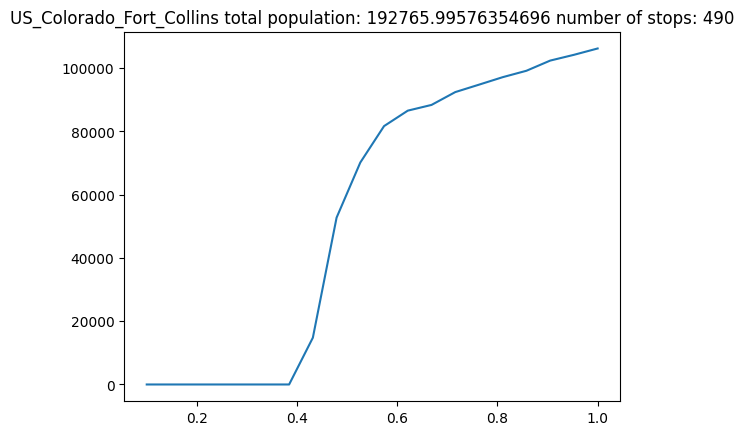

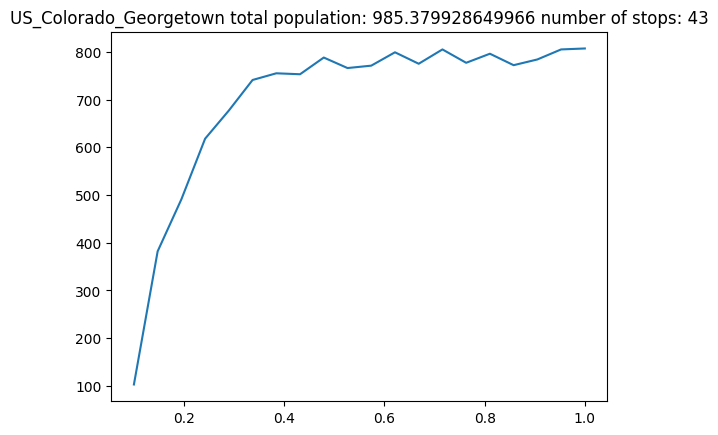

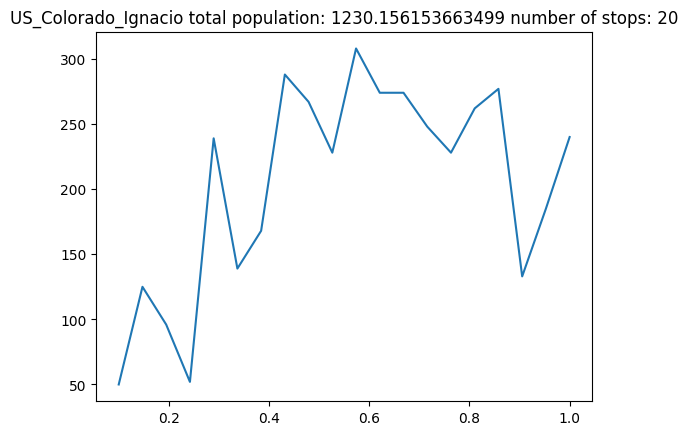

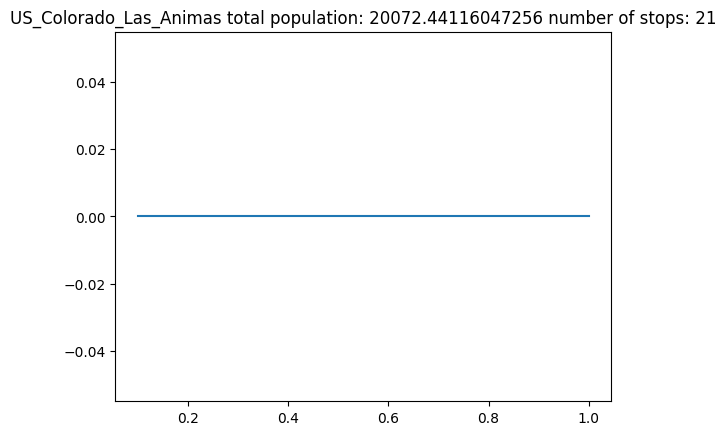

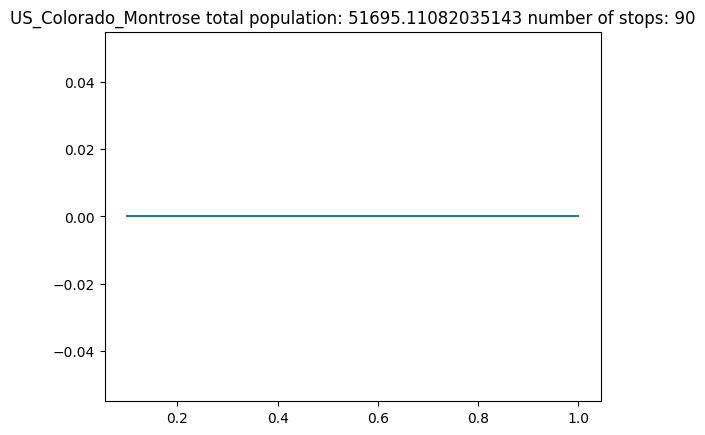

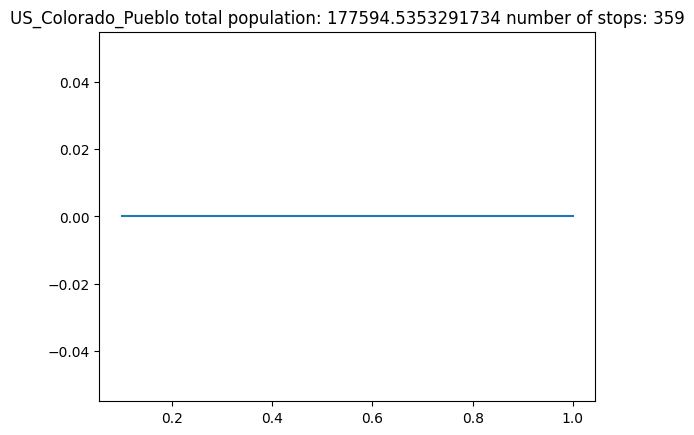

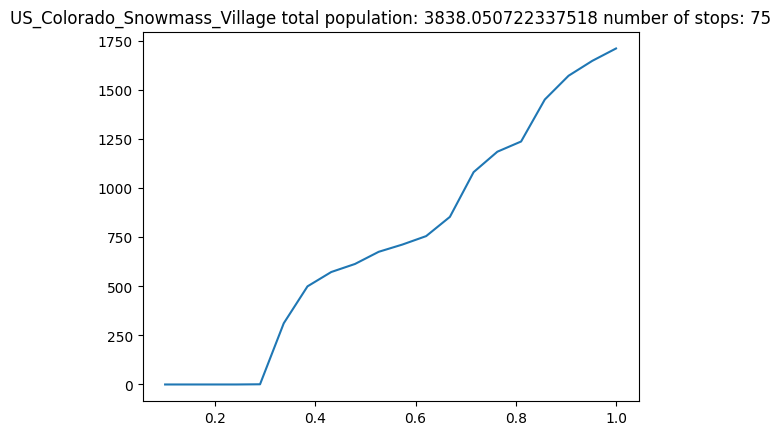

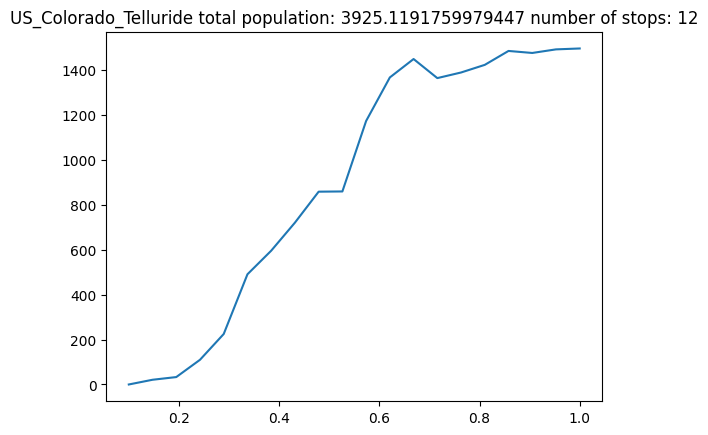

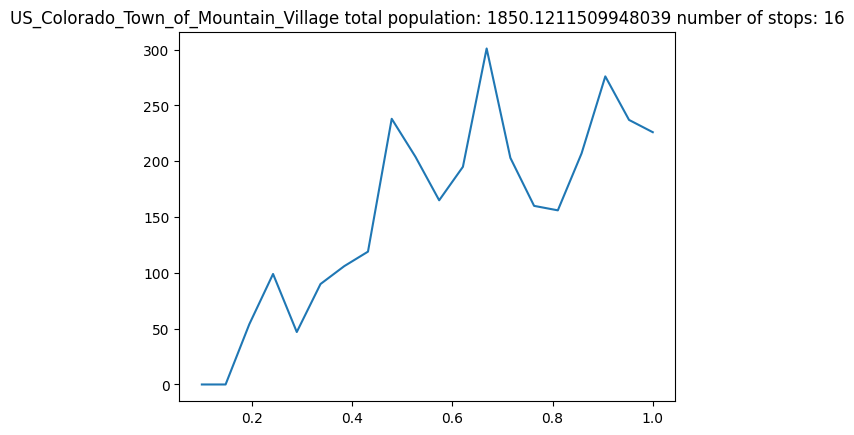

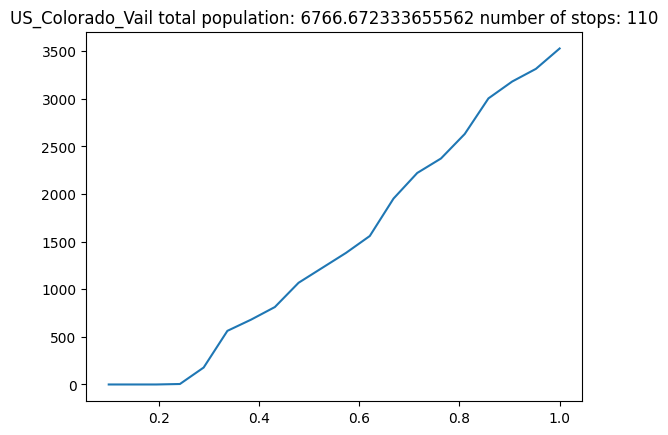

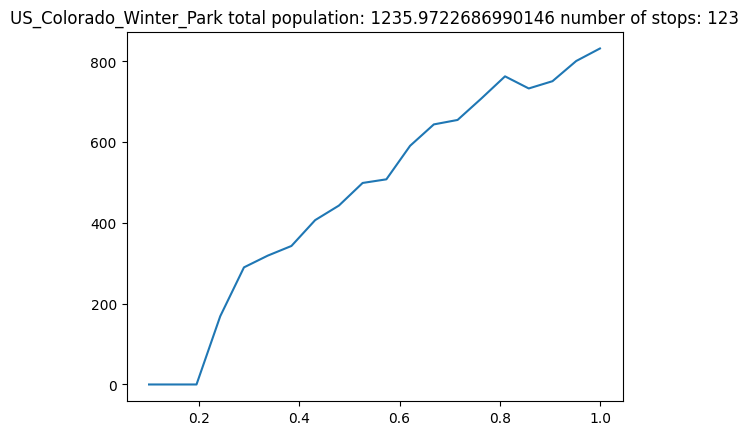

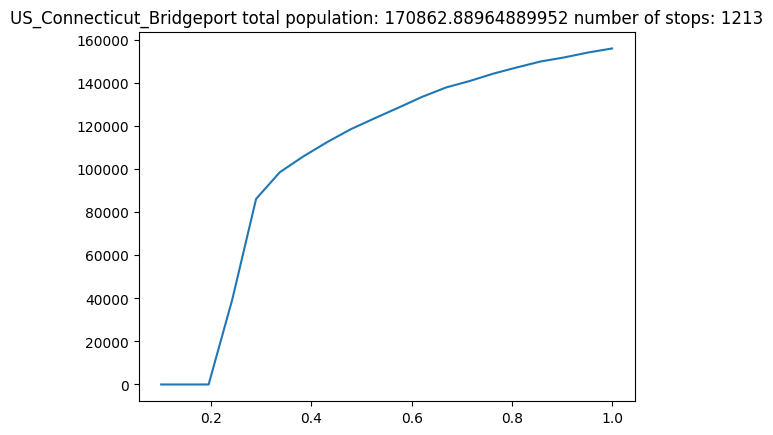

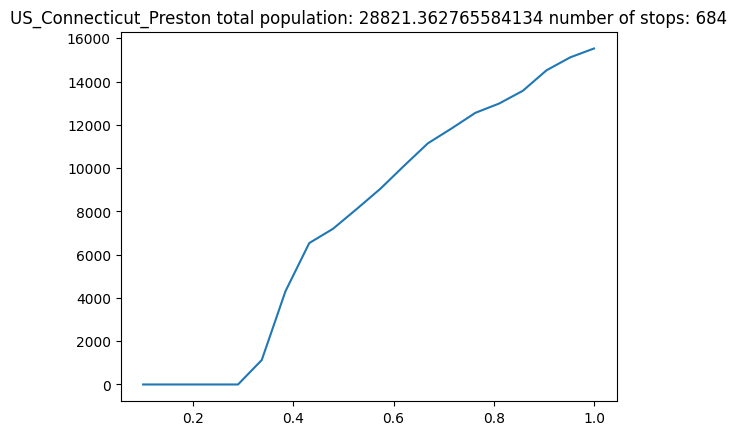

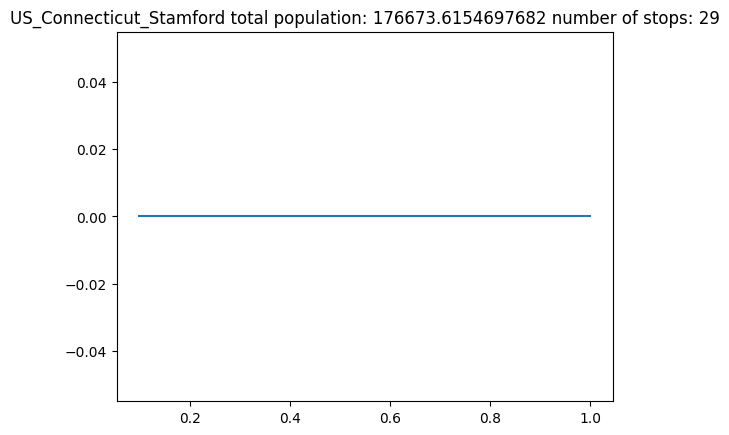

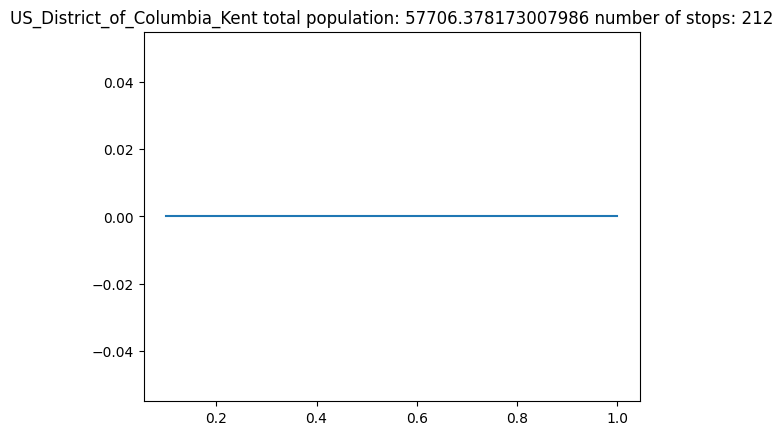

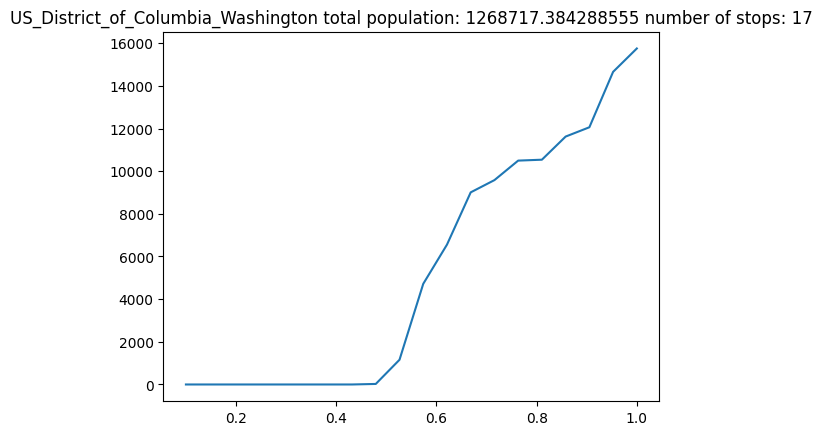

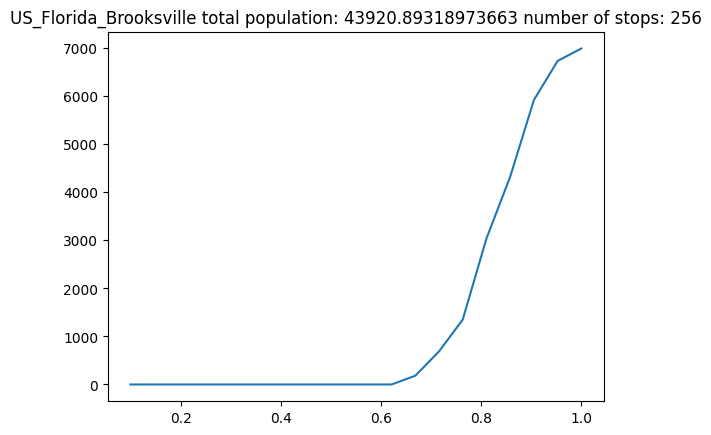

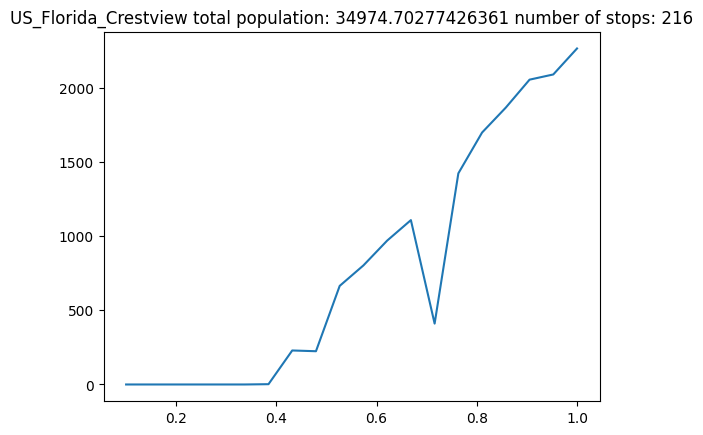

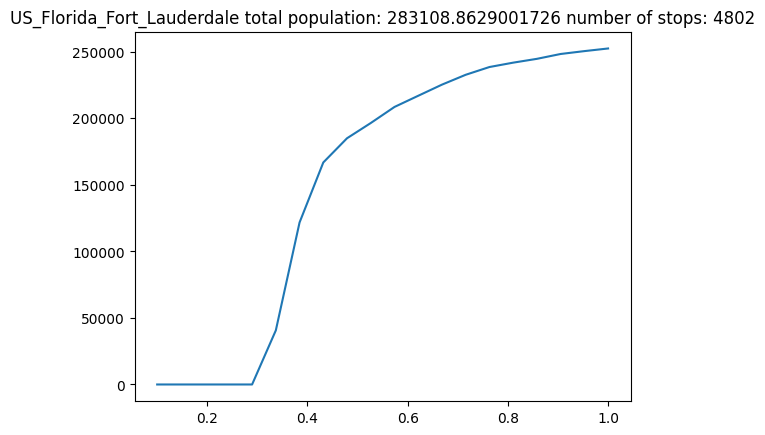

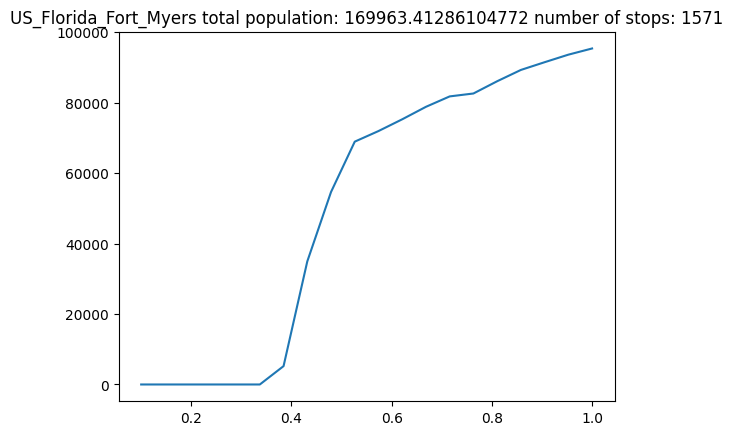

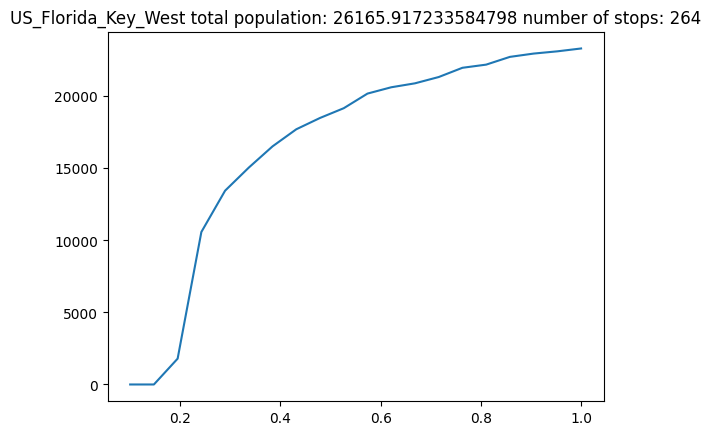

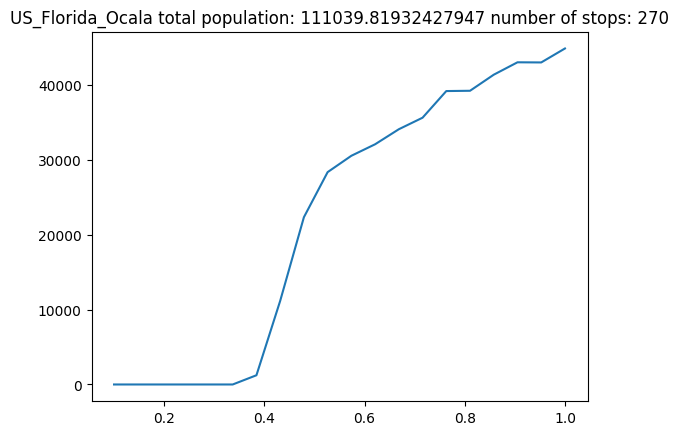

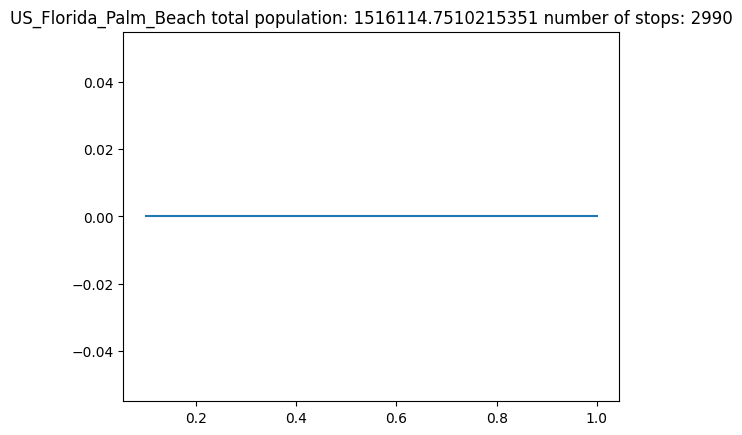

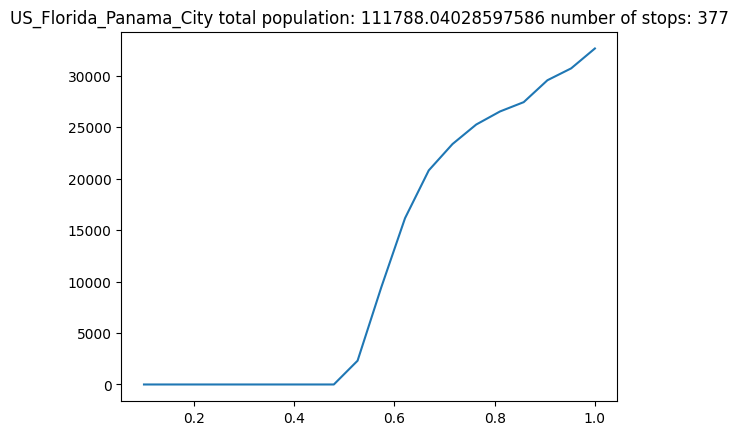

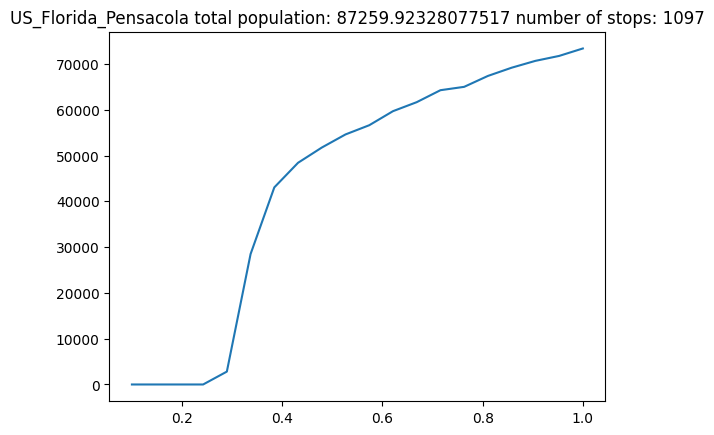

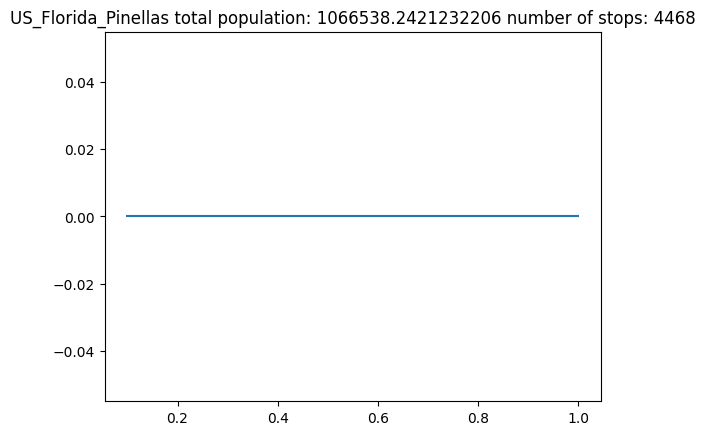

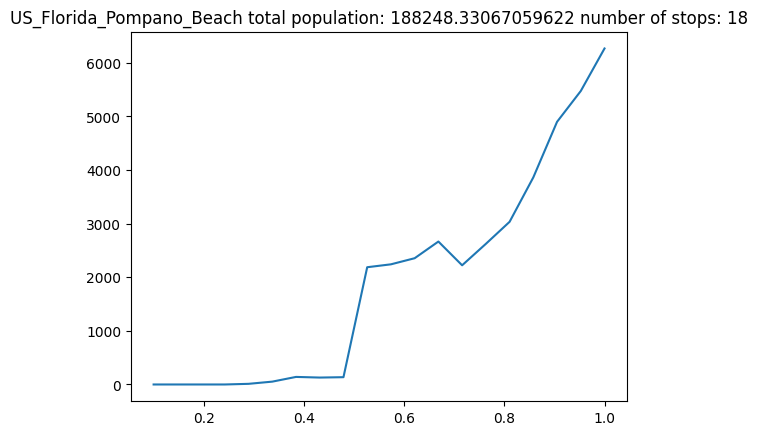

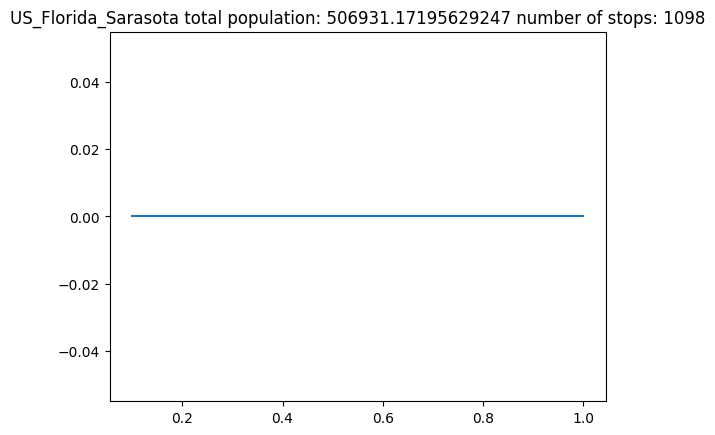

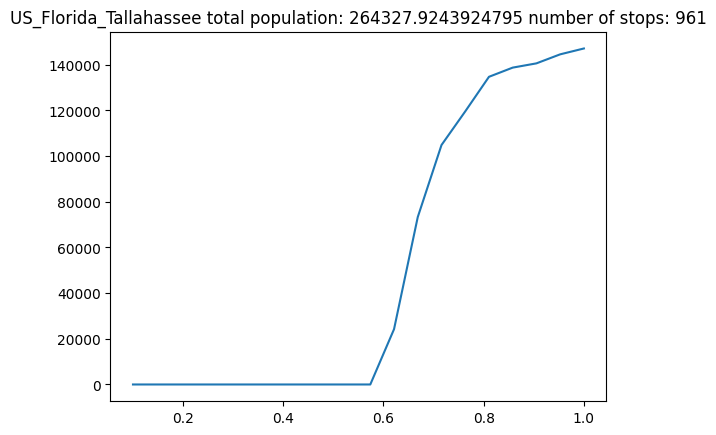

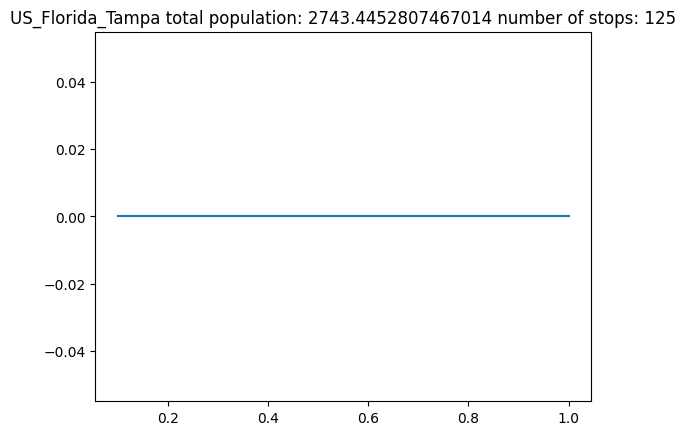

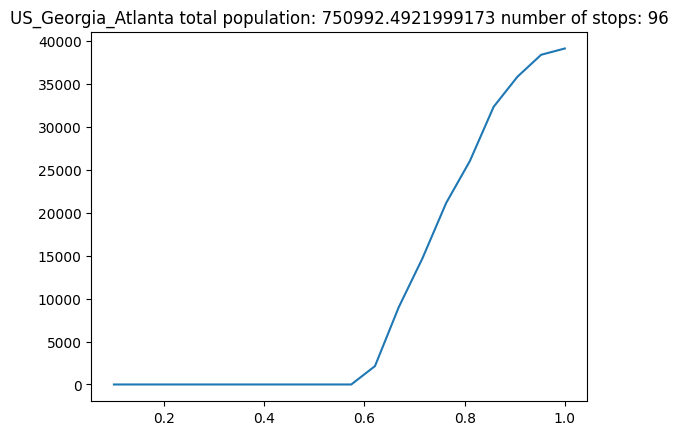

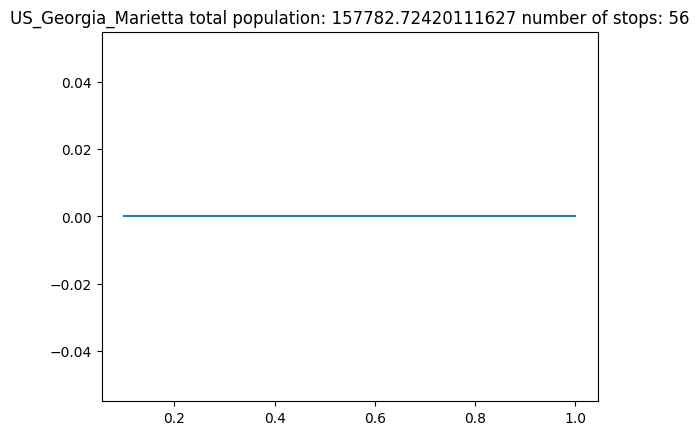

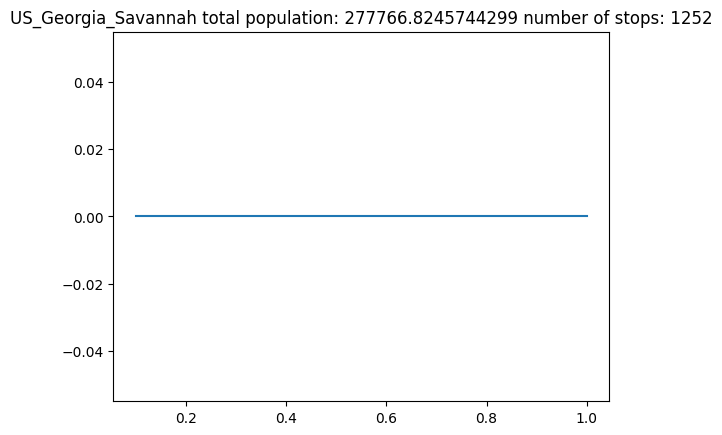

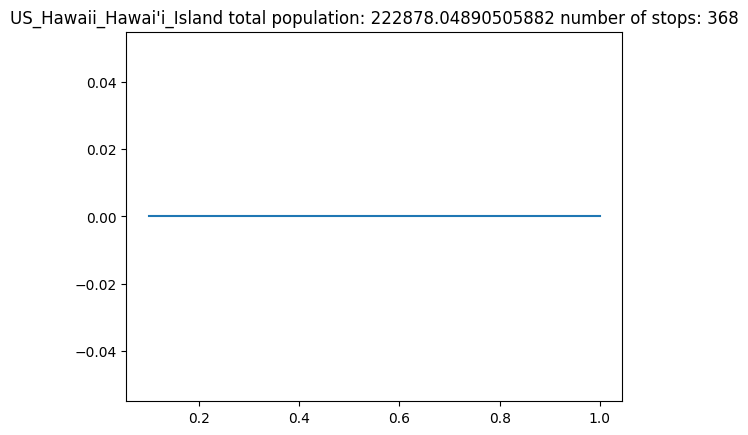

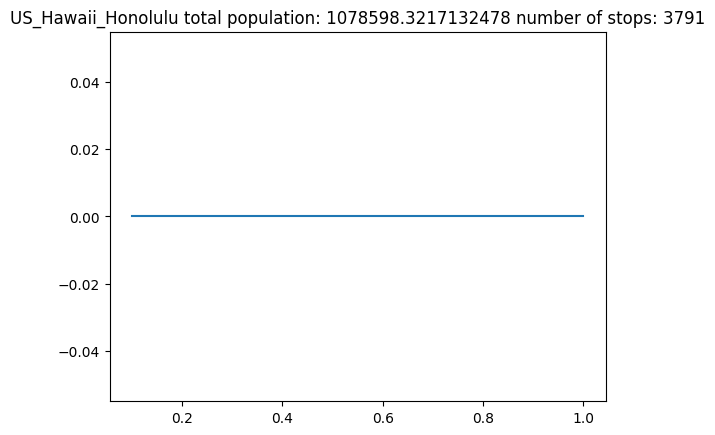

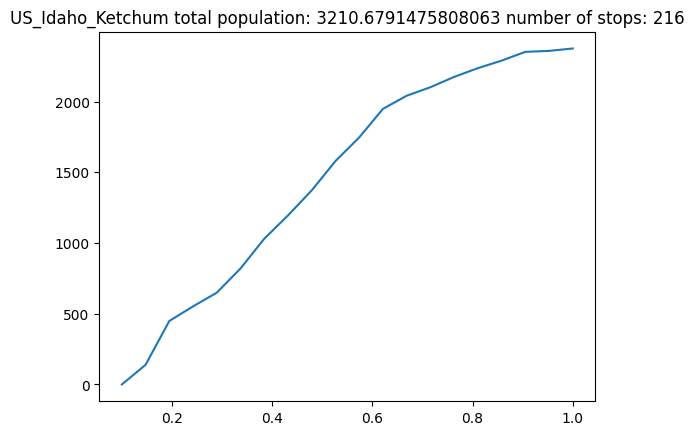

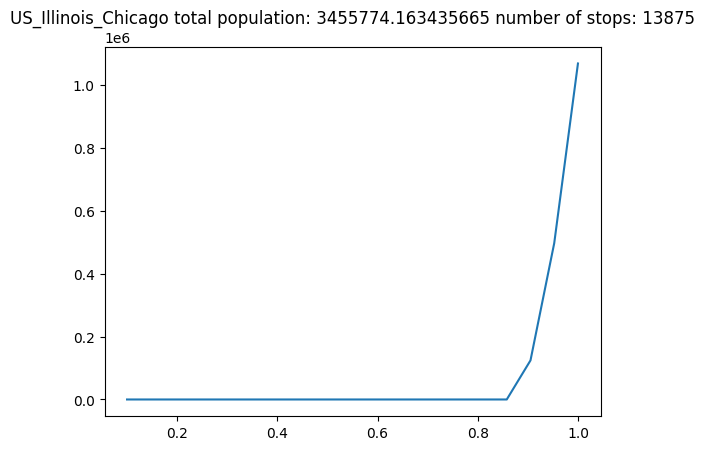

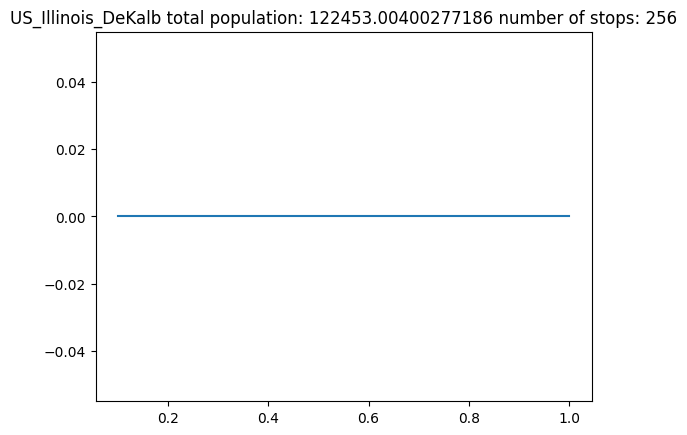

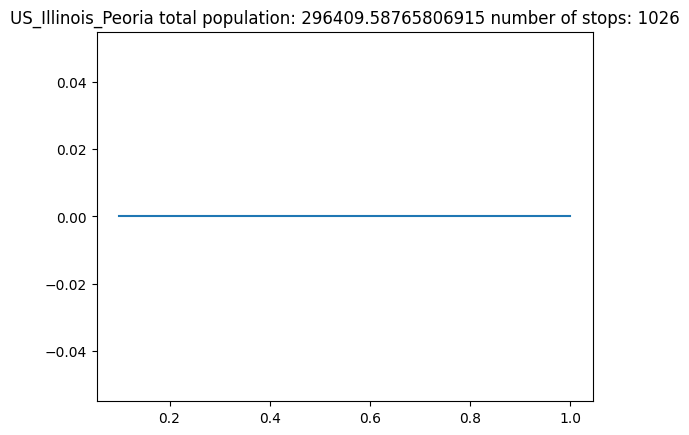

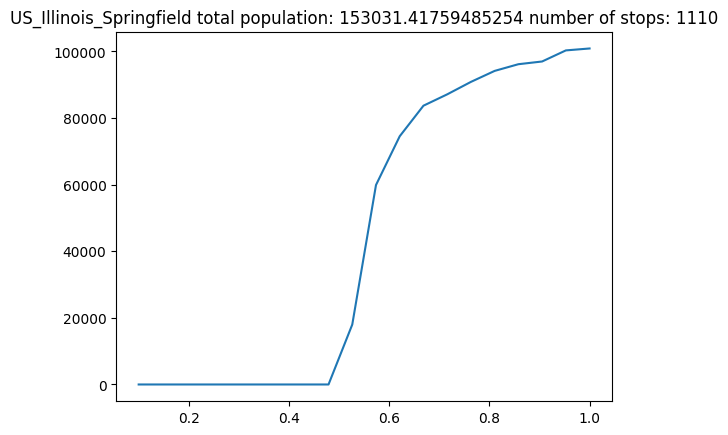

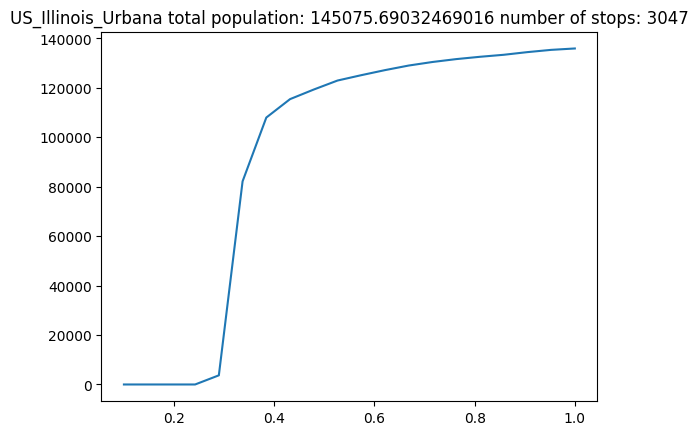

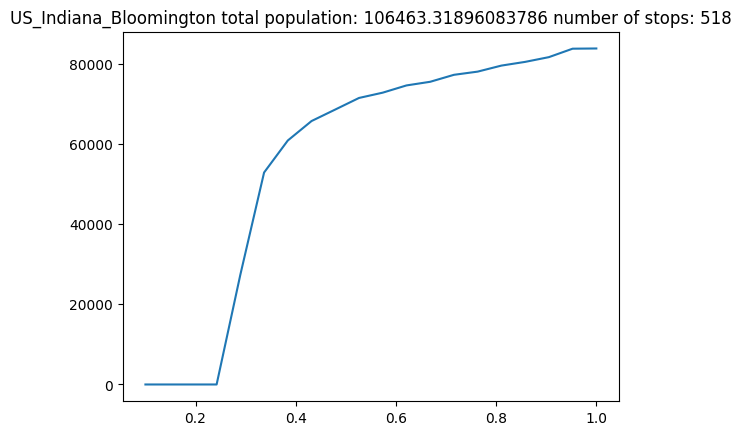

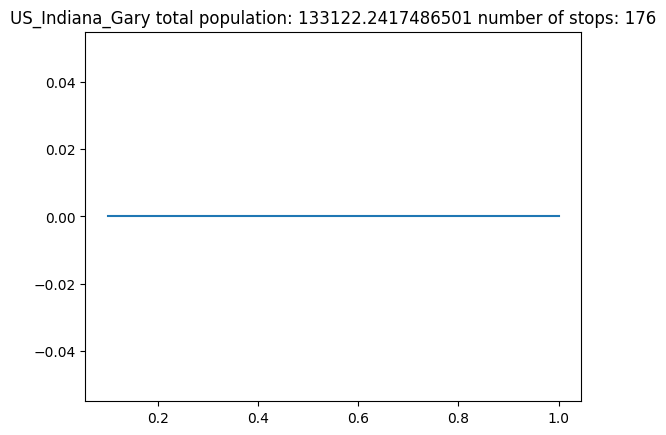

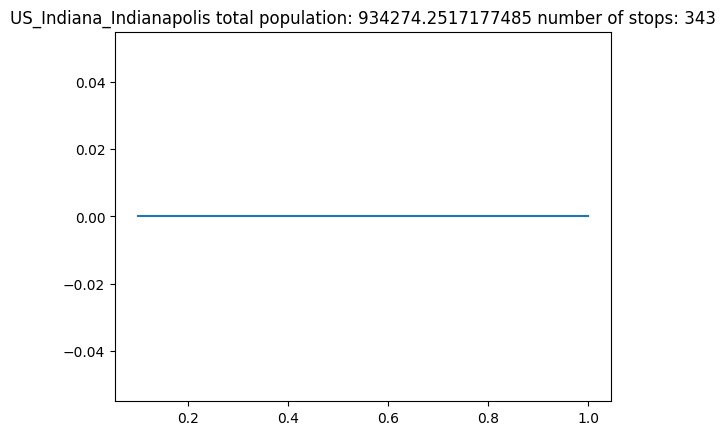

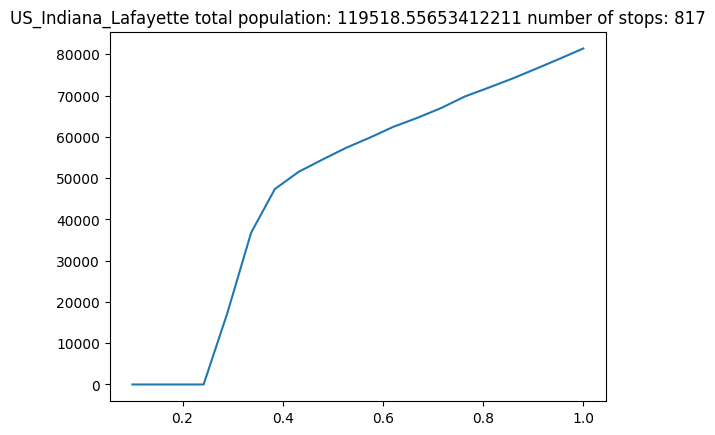

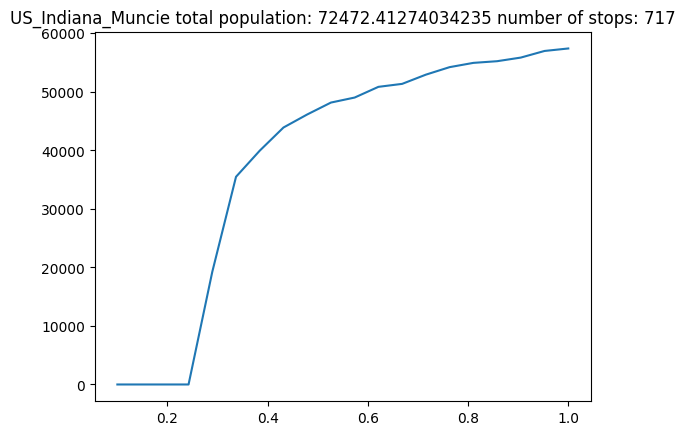

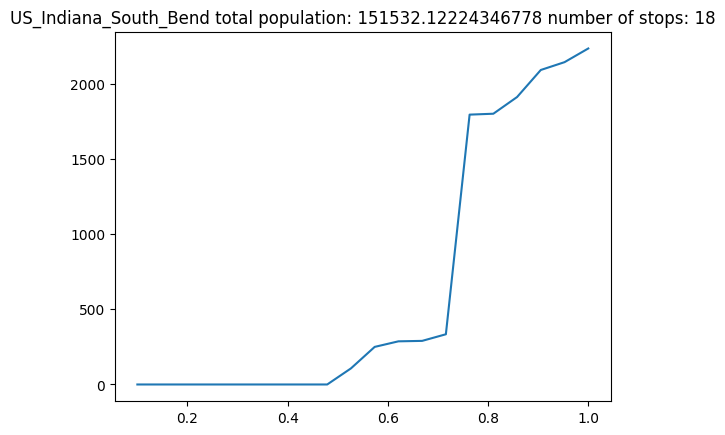

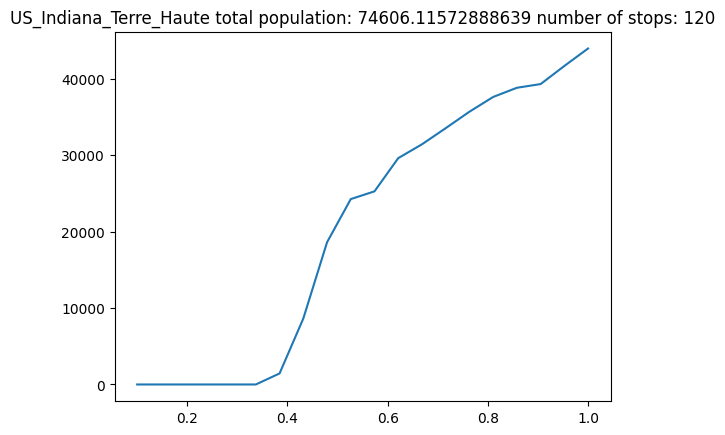

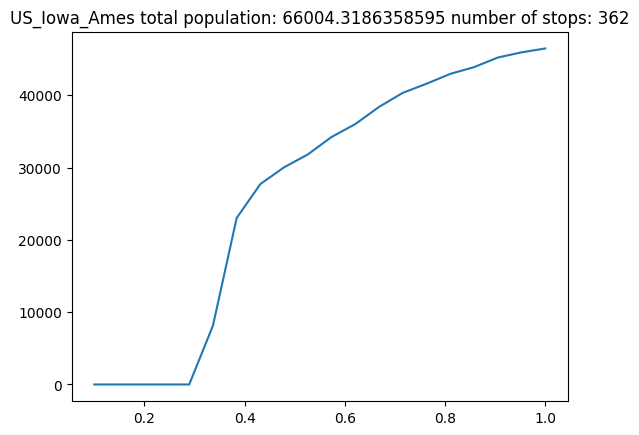

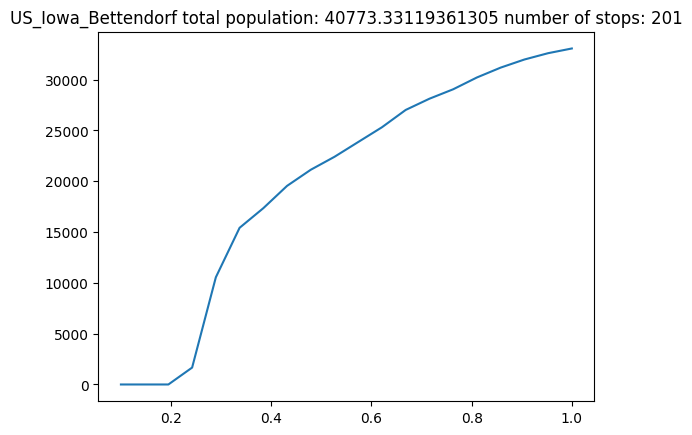

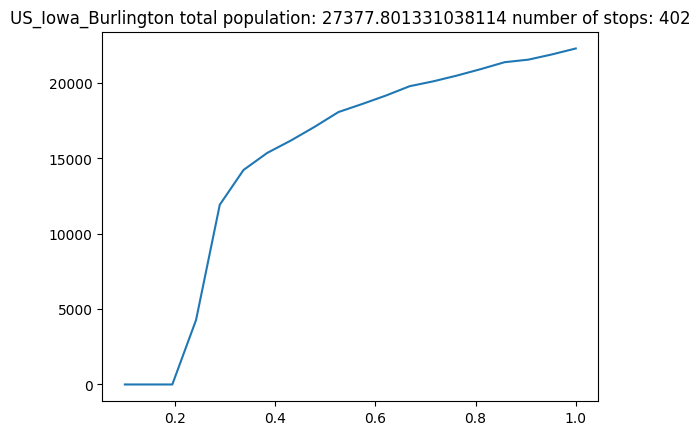

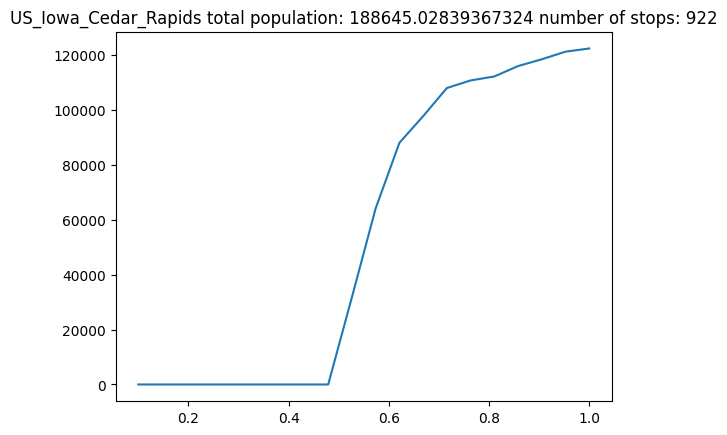

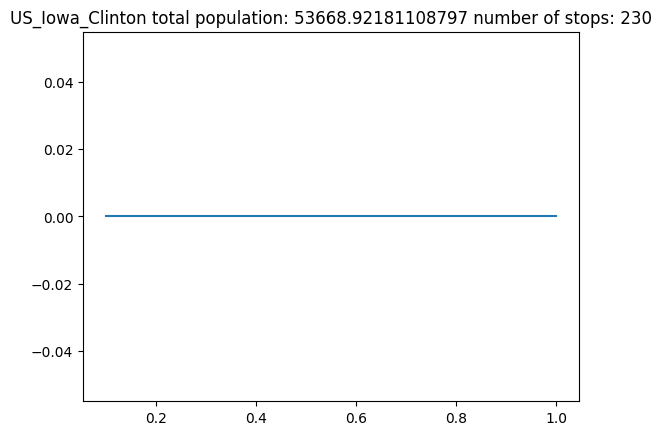

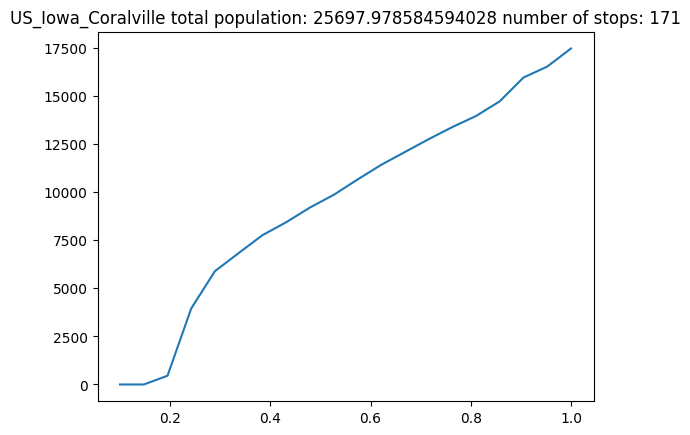

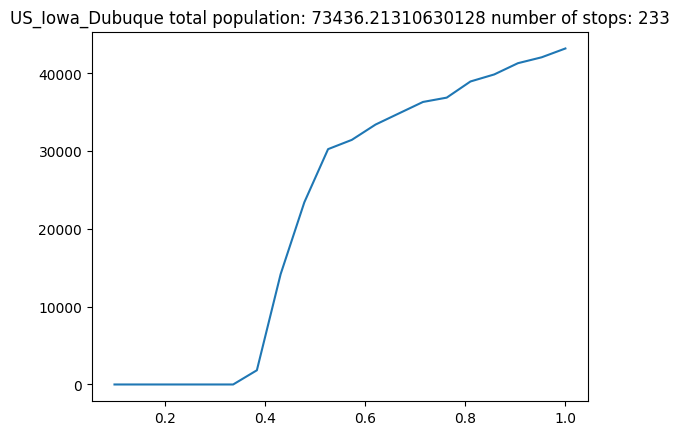

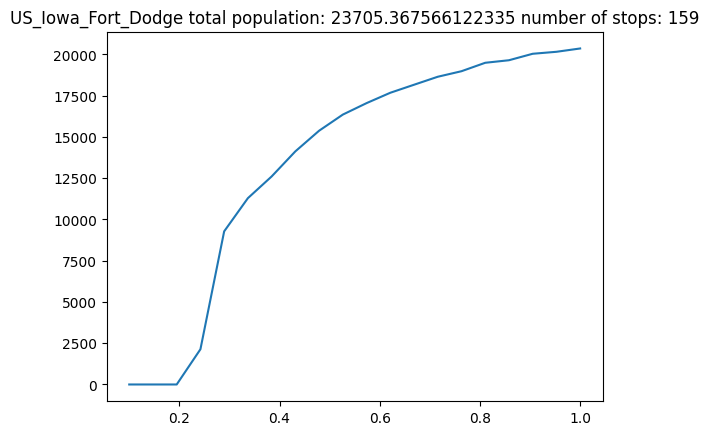

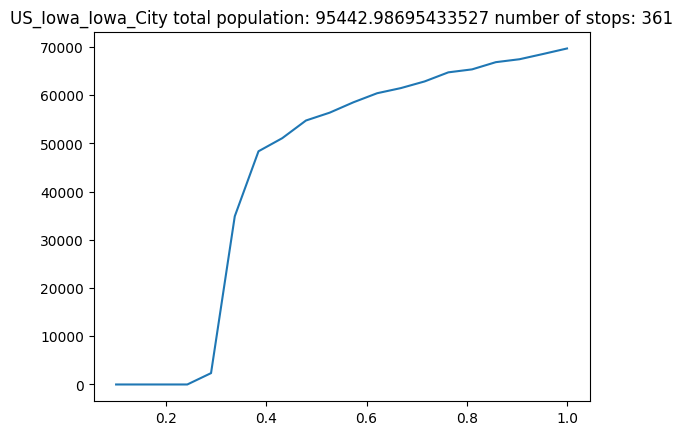

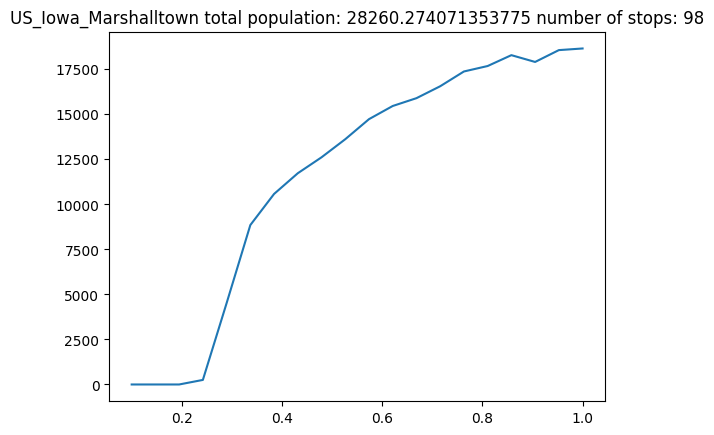

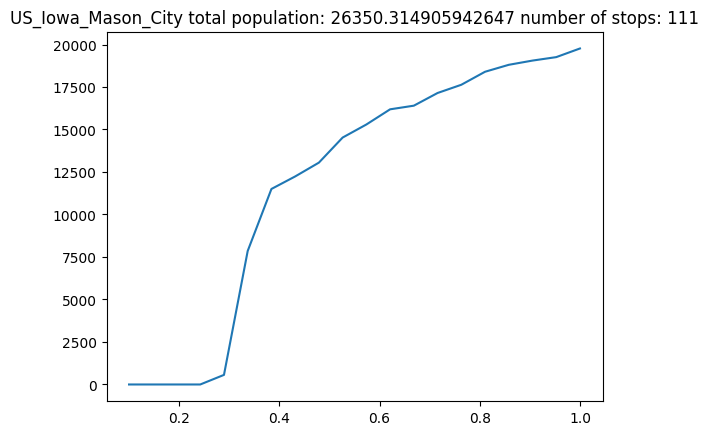

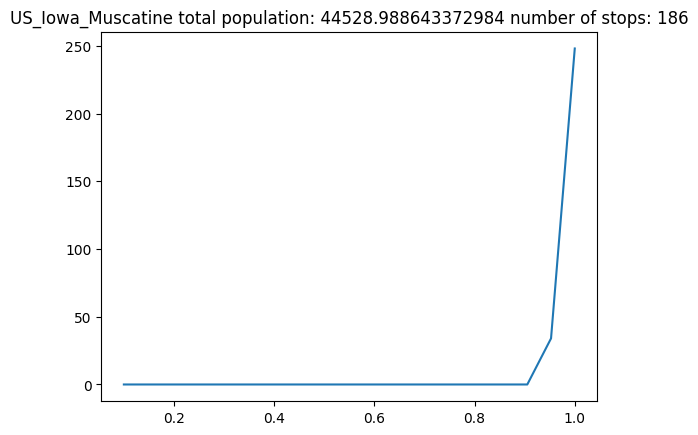

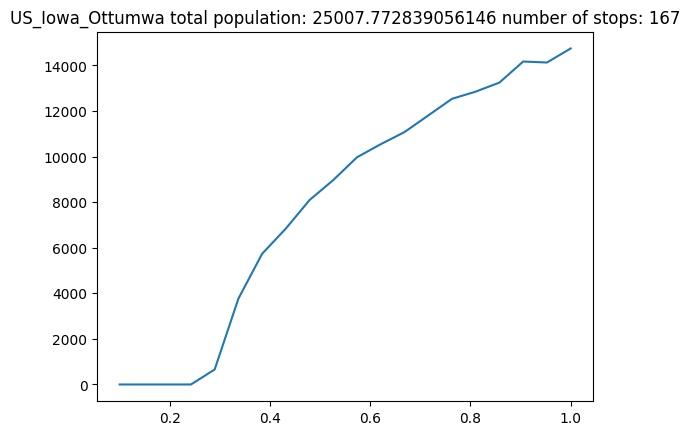

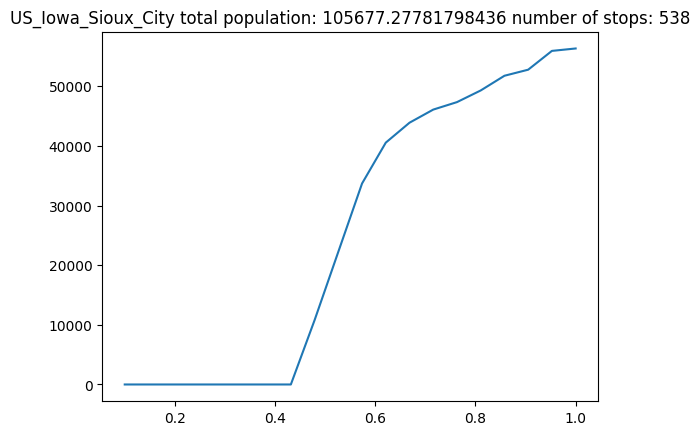

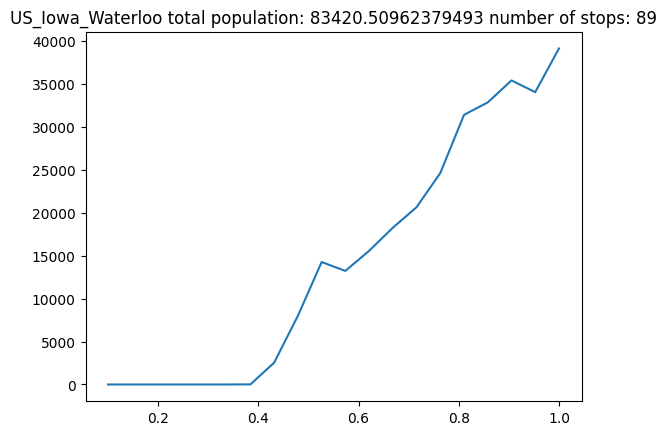

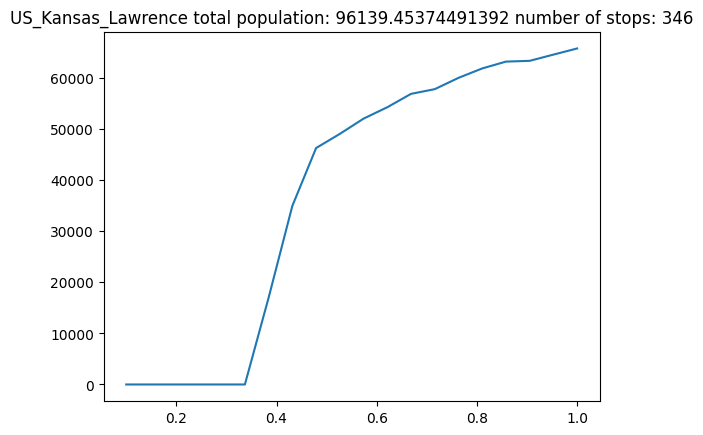

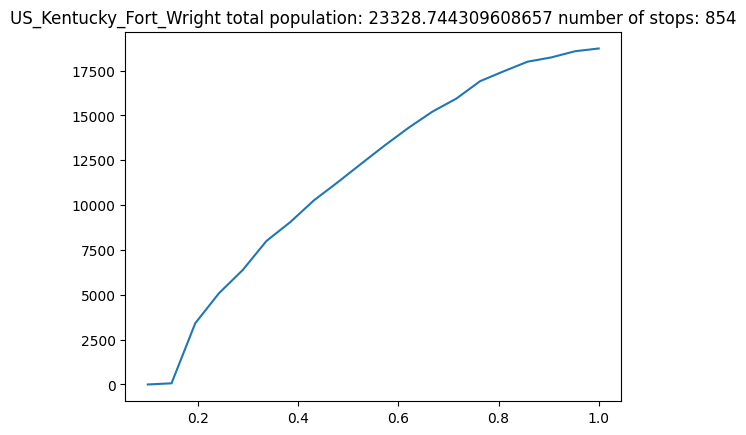

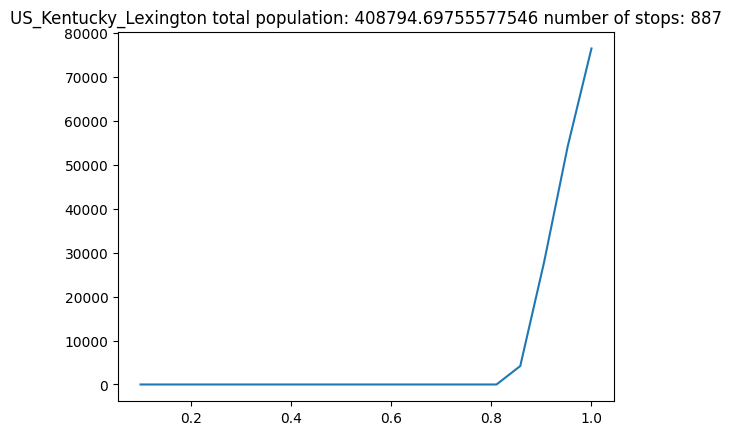

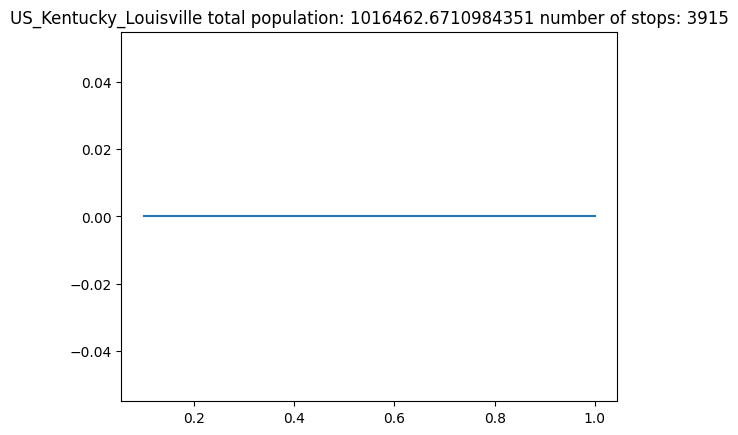

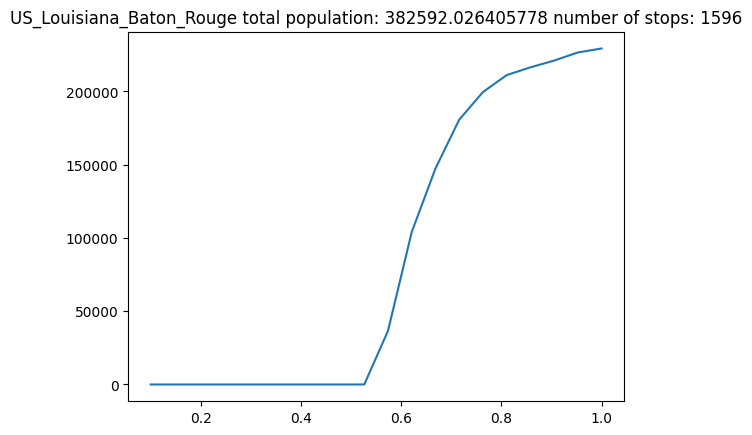

KeyboardInterrupt: 

In [7]:
global LATMAX, LONMAX, LATMIN, LONMIN

GRIDSIZE = 250



# get all city names in the dataset
all_city_paths = glob.glob("data/*")
all_city_paths.pop(0)


# for each city look up square coordinates
for city_name in all_city_paths:


    POPULATIONGRID = [[0 for i in range(GRIDSIZE)] for j in range (GRIDSIZE)]
    STOPSGRID = [[0 for i in range(GRIDSIZE)] for j in range (GRIDSIZE)]

    better_name = os.path.basename(city_name)

    # get coordinates in square around city center
    resp = r.get("https://api.maptiler.com/geocoding/legacy/q/" + better_name +".js?key=XsDCgwk8uMC75zY8VXtN")
    LATMIN, LONMIN, LATMAX, LONMAX = resp.json()["results"][0]["boundingbox"] 

    if ((LATMIN == LATMAX) or (LONMIN == LONMAX)): continue

    # 7 sekunden schneller wenns in zwei lines ist
    new_df = df[(df.x >= LATMIN) & (df.x <= LATMAX)]
    new_df = new_df[(new_df.y >= LONMIN) & (new_df.y <= LONMAX)]
    
    # visualize the dataframe
    visualize(new_df, better_name)

    # convert to list
    x = new_df["x"].tolist()
    y = new_df["y"].tolist()
    weight = new_df["weight"].tolist()


    # skip the loop if the coorinates are outside the bounding box
    skip_loop = False
    for testx, testy, _ in zip(x,y,weight):
        if not (LATMAX >= testx and testx >= LATMIN and LONMAX >= testy and testy >= LONMIN): 
            # set variable to skip outer loop
            skip_loop = True
            
    if skip_loop: 
        print("skipped, coordinates:", testx, testy)
        skip_loop = False
        continue


    # get grid indices
    for x1, y1, w1 in zip(x,y, weight):
    
        xind, yind = getindices(x1,y1, LATMIN, LONMIN, LATMAX, LONMAX, GRIDSIZE)
        POPULATIONGRID[yind][xind] += w1

    TOTALPOP = np.sum(POPULATIONGRID)
    # print("Number of Inhabitants: ", TOTALPOP)

    # we assume that the boundingbox is a square, makes calculations easier and ___shoudldnt___ interfere toooooo much with the rest
    diagonal = hs.haversine(( LONMAX, LATMAX), (LONMIN, LATMIN))
    side = diagonal / m.sqrt(2)
    onepxlength = side / GRIDSIZE # length of one pixel in grid in KM

    # load relevant stops
    all_stops = load_stops_as_dict(better_name)
    STOPSNUMBER = len(all_stops.keys())

    # loop over all the stops
    for stop in all_stops.keys():
        lat, lon = all_stops[stop]
        xind, yind = getindices(lon, lat, LATMIN, LONMIN, LATMAX, LONMAX, GRIDSIZE)

        if (0 <= yind < GRIDSIZE) and (0 <= xind < GRIDSIZE):
            STOPSGRID[yind][xind] += 1


    # analyze reachability
    SAMPLES = 20
    START_RADIUS = 0.1 # in KM
    STOP_RADIUS = 1 # in KM

    radius_list = np.linspace(START_RADIUS, STOP_RADIUS, SAMPLES)

    all_x = []
    all_y = []

    for i in radius_list:

        # Lousiana Baton Rouge machts kaputt


        convolved_stopsgrid = convolve_stopgrid(i, onepxlength, STOPSGRID)

        all_y.append(analyze_grids(convolve_stopgrid(i, onepxlength, STOPSGRID), POPULATIONGRID, TOTALPOP))
        all_x.append(i)

    plt.plot(all_x, all_y)
    plt.title(better_name + " total population: " + str(TOTALPOP) + " number of stops: " + str(STOPSNUMBER))  
    plt.savefig("plots/reachability_" + better_name + ".png")
    plt.show()
    plt.close()
      